# IMPORTS

In [71]:
import yaml
import firebase_admin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from scipy import stats
import seaborn as sns

import requests
import json

import time

import unidecode

from math import sin, cos, sqrt, atan2, radians


from firebase_admin import credentials
from firebase_admin import firestore

from matplotlib import pyplot

from matplotlib.patches import Polygon
from pandas.plotting import scatter_matrix

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from datetime import datetime



# CONNECT TO FIREBASE

In [2]:
filename='/Users/5danalfaro/OAN/credentials/firebase_parameters.json'

In [3]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

### FUNCTIONS

In [4]:
def distance(p_1,p_2):
    # approximate radius of earth in m
    R = 6373000

    lat1 = radians(p_1['lat'])
    lon1 = radians(p_1['lon'])
    lat2 = radians(p_2['lat'])
    lon2 = radians(p_2['lon'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [5]:
def has_been_survey(x):
    p_1={'lat':float(x['lat']),'lon':float(x['lon'])}
    points=df_priority.apply(lambda x: True
                             if distance(p_1,{'lat':x['latitude'],'lon':x['longitude']}) <40
                             else False
                                        ,axis=1)
    return points.any()

In [6]:
def n_houses(x):
    p_1={'lat':x['latitude'],'lon':x['longitude']}
    points=df_houses.apply(lambda x: True
                             if distance(p_1,{'lat':x['lat'],'lon':x['lon']}) <40
                             else False
                                        ,axis=1)
    return points.sum()

# GET VILLAGE AND PRIORITY SURVEYS

In [20]:
col_query = db.collection('Surveys').document('Backup').collection('Answers').where(u'survey_type', u'==', u'2-survey_priority')


In [21]:
col_sur_priority = col_query.stream()

In [22]:
l_sur_priority = []
for doc in col_sur_priority:
    l_sur_priority.append(doc.to_dict())

In [23]:
for a in l_sur_priority:
    if not 'coords' in a.keys():
        print(a)

In [24]:
len(set([a['coords']['longitude'] for a in l_sur_priority]))

175

In [25]:
col_query = (db.collection('Surveys').
                    document('Backup').
                        collection('Answers').
                            where(u'survey_type', u'==', u'1-survey_village')
            )

In [26]:
col_sur_village = col_query.stream()

In [27]:
l_sur_village = []
for doc in col_sur_village:
    l_sur_village.append(doc.to_dict())

In [28]:
len(set([a['data']['village_coords'] for a in l_sur_village]))

25

In [29]:
len(l_sur_village)

25

In [30]:
vil_names=[vil['data']['village_name'].lower() for vil in l_sur_village]
vil_names.sort()
vil_names

['alafiarou',
 'bah boré',
 'bio sika kparou ',
 'chein gbérou kpanin',
 'danon',
 'debbo',
 'gamborou',
 'gaoude',
 'gbérou kpanin',
 'gnankpare',
 'gnel dama',
 'gongue kparou',
 'gongué kparou',
 'gongué kparou',
 'goumankou',
 'kora seko kparou où sansi gah gourou',
 'kparisserou peulh',
 "sanni djoulde n'gando",
 'sergent kparou',
 'sonkorou',
 'tata lafiarou ou djonwouro kparou ',
 'tchoukakparou',
 'trabo',
 'wodora',
 'yassinrou']

In [31]:
s_vil_names=set(vil_names)
len(s_vil_names)

24

In [32]:
[vil['data']['village_pop'] for vil in l_sur_village]

['400',
 '200',
 '200',
 '200',
 '100',
 '350',
 '70',
 '120',
 '150',
 '120',
 '150',
 '180',
 '150',
 '180',
 '150',
 '150',
 '80',
 '500',
 '180',
 '250',
 '300',
 '200',
 '80',
 '150',
 '100']

# PROCESS DATA

## PRIORISATION DATA

In [184]:
df_priority=pd.DataFrame([{
    'coords':doc['coords'],
    'latitude':doc['coords']['latitude'],
  'longitude':doc['coords']['longitude'],
  'creation_date':doc['creation_date'],
  'nb_basin':doc['data']['nb_basin'],
  'nb_people':doc['data']['nb_people'],
  'nb_diarrhoea':doc['data']['nb_diarrhoea'],
  'nb_malnu':doc['data']['nb_malnu'],
  'water_storage':doc['data']['water_storage'],
  'water_quality':doc['data']['water_quality'],
  'self_manag':doc['data']['self_manag'],
  'role':doc['data']['role']
  
    } for doc in l_sur_priority
])

In [185]:
df_priority=df_priority.drop_duplicates(subset=['longitude','latitude']).reset_index()

In [186]:
df_priority=df_priority.drop('index',axis=1)

In [187]:
df_priority.latitude=pd.to_numeric(df_priority.latitude,errors='coerce')

In [188]:
df_priority.longitude=pd.to_numeric(df_priority.longitude,errors='coerce')

## Village data

In [38]:
df_village=pd.DataFrame(
    [{#'latitude':doc['coords']['latitude'],
      #'longitude':doc['coords']['longitude'],
      'village_coords':doc['data']['village_coords'],
      'creation_date':doc['creation_date'],
      'nb_water_sources':doc['data']['nb_water_sources'],
      'heath_center':doc['data']['heath_center'],
      'village_pop':doc['data']['village_pop'],
      'village_name':doc['data']['village_name'],
      'water_sources':doc['data']['water_sources']

        } for doc in l_sur_village
    ]
)

In [39]:
df_village=df_village.drop_duplicates(subset='village_coords')

In [40]:
df_village=df_village.drop_duplicates(subset='village_name')

In [41]:
df_village=df_village.reset_index()

In [42]:
df_village=df_village.drop('index',axis=1)

In [43]:
df_village['longitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[1],axis=1)

In [44]:
df_village['latitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[0],axis=1)

In [45]:
l_s_potable= ['PPM','AEV','FPM']

In [46]:
df_village['%_s_potable']=df_village.apply(
    lambda x: 100*(len([source['ws_type'] 
                   for source in x['water_sources'] if source['ws_type'] in l_s_potable])
                /float(x['nb_water_sources']))
    ,axis=1
)

In [47]:
def vilcords(x):      
    vil_coords=x['village_coords']
    vil_lat = float(vil_coords.split(' ;')[0])
    vil_lon = float(vil_coords.split(' ;')[1])
    return pd.Series([vil_lat,vil_lon])

In [48]:
df_village[['latitude','longitude']]=df_village.apply(lambda x: vilcords(x), axis=1)

### merge village and priority

In [194]:
villages = []
for village in df_village.village_name.to_list():
    isinlist=0
    for vil in villages:
        if fuzz.ratio(unidecode.unidecode(vil.lower()),unidecode.unidecode(village.lower()))>90:
            isinlist=1
    if isinlist:
        continue
    else:
        villages.append(village)

In [195]:
len(villages)

23

In [196]:
villages.sort()

In [197]:
villages

['Alafiarou',
 'Bah Boré',
 'Bio Sika Kparou ',
 'Chein Gbérou Kpanin',
 'Danon',
 'Debbo',
 'GNEL DAMA',
 'Gamborou',
 'Gaoude',
 'Gbérou kpanin',
 'Gnankpare',
 'Goumankou',
 'Kora seko Kparou où Sansi Gah Gourou',
 'Kparisserou peulh',
 "SANNI DJOULDE N'GANDO",
 'Sergent Kparou',
 'Sonkorou',
 'Tata Lafiarou ou Djonwouro Kparou ',
 'Tchoukakparou',
 'Trabo',
 'Wodora',
 'Yassinrou',
 'gongué kparou']

In [198]:
s_vil_names-set([vil.lower() for vil in villages])

{'gongue kparou'}

In [199]:
vil_1=set(villages)

In [78]:
for i,doc in enumerate(l_sur_priority):
    if 'village' in doc['data'].keys():
        village = doc['data']['village']
        isinlist=0
        for vil in villages:
            if fuzz.ratio(unidecode.unidecode(vil.lower()),unidecode.unidecode(village.lower()))>91:
                isinlist=1
        if isinlist:
            continue
        else:
            villages.append(village)

In [79]:
len(villages)

26

In [80]:
set(villages)-vil_1

{'Baoure', 'Gaoure', 'Gaouro'}

In [200]:
df_village=df_village[df_village['village_name'].isin(villages)].reset_index().drop('index',axis=1)

In [201]:
'''get village from minimum distance to survey (and date of creation date)'''
def get_village(x):
    prior_cre_date=datetime.strptime(x['creation_date'],'%Y-%m-%dT%H:%M:%S.%fZ')
    for doc in l_sur_priority:
        if doc['coords'] == x['coords']:
            if 'village' in doc['data'].keys():
                vil=process.extractOne(doc['data']['village'],villages)[0]
                vil_time=df_village[df_village['village_name']==vil]['creation_date'].values[0]
                vil_time=datetime.strptime(vil_time,'%Y-%m-%dT%H:%M:%S.%fZ')
                diff_time = vil_time-prior_cre_date
                return pd.Series([vil,'vill',diff_time.seconds/3600])
    min_dist=1
    village=''
    lat=float(x['latitude'])
    lon=float(x['longitude'])
    for vil_coords,vil_name,creat_date in zip(df_village['village_coords'].to_list(),
                                   df_village['village_name'].to_list(),
                                   df_village['creation_date'].to_list()
                                  ):
        vil_lat = float(vil_coords.split(' ;')[0])
        vil_lon = float(vil_coords.split(' ;')[1])
        
        distance=((vil_lat-lat)**2+(vil_lon-lon)**2)**0.5
        if min_dist > distance:
            min_dist=distance
            village=vil_name
            vil_time=datetime.strptime(creat_date,'%Y-%m-%dT%H:%M:%S.%fZ')
            diff_time = vil_time-prior_cre_date
    #print(prior_cre_date[5:10],
    #      df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     prior_cre_date[5:10]==df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     village)
    #        
    if village:
        return pd.Series([process.extractOne(village,villages)[0],'coords',diff_time.seconds/3600])
    else:
        return pd.Series(['NaN','NaN','NaN'])
        

In [202]:
df_priority[['village','source_name','dif_time']]=df_priority.apply(lambda x: get_village(x),axis=1)

In [203]:
len(df_priority['village'].unique())

18

In [204]:
df_priority['source_name'].value_counts()

coords    120
vill       54
Name: source_name, dtype: int64

In [192]:
df_priority=df_priority.drop(df_priority[df_priority['source_name']=='NaN'].index[0])

In [193]:
df_priority=df_priority.reset_index().drop('index',axis=1)

In [113]:
vil_1-set(df_priority['village'].unique())

{'Gamborou', 'Gbérou kpanin', 'Goumankou', 'Sergent Kparou', 'Wodora'}

In [205]:
for vil in (vil_1-set(df_priority['village'].unique())):
    print(df_village[df_village['village_name']==vil]['village_coords'])

20    9.7899017 ; 3.3060967
Name: village_coords, dtype: object
9    9.881265 ; 3.2157467
Name: village_coords, dtype: object
7    9.8334188 ; 3.0378204
Name: village_coords, dtype: object
15    9.89611 ; 2.9369243
Name: village_coords, dtype: object
11    9.8965883 ; 2.9977602
Name: village_coords, dtype: object


### check village asignation to surveys

#### by date

In [206]:
df_priority.dif_time=pd.to_numeric(df_priority.dif_time, errors='coerce')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

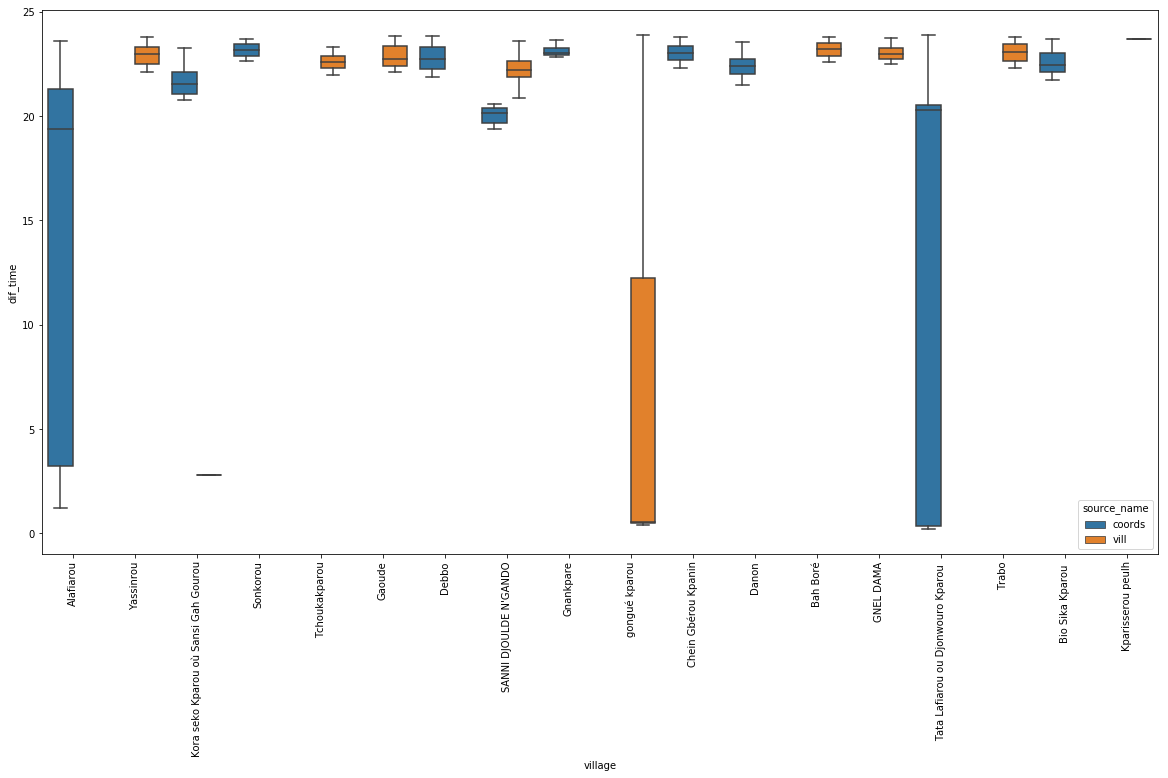

In [207]:
plt.rcParams['figure.figsize']=20,10
sns.boxplot(y='dif_time',x='village',hue='source_name',data=df_priority)
plt.xticks(rotation=90)

## CHECK CLOSE VILLAGE DATA

In [118]:
'''get village from minimum distance to survey (and date of creation date)'''
def get_close_vil(x):
    close_vil=[]
    p_1={'lat':float(x['latitude']),'lon':float(x['longitude'])}
    for vil_coords,vil_name in zip(df_village['village_coords'].to_list(),
                                   df_village['village_name'].to_list()
                                  ):
        vil_lat = float(vil_coords.split(' ;')[0])
        vil_lon = float(vil_coords.split(' ;')[1])
        p_2={'lat':vil_lat,'lon':vil_lon}
        
        dist=distance(p_1,p_2)
        
        if dist<5000 and dist>100:
            close_vil.append(vil_name)
    return close_vil
        

In [119]:
df_village['close_vil']=df_village.apply(lambda x: get_close_vil(x),axis=1)

In [120]:
df_village=df_village.sort_values(by='village_name')

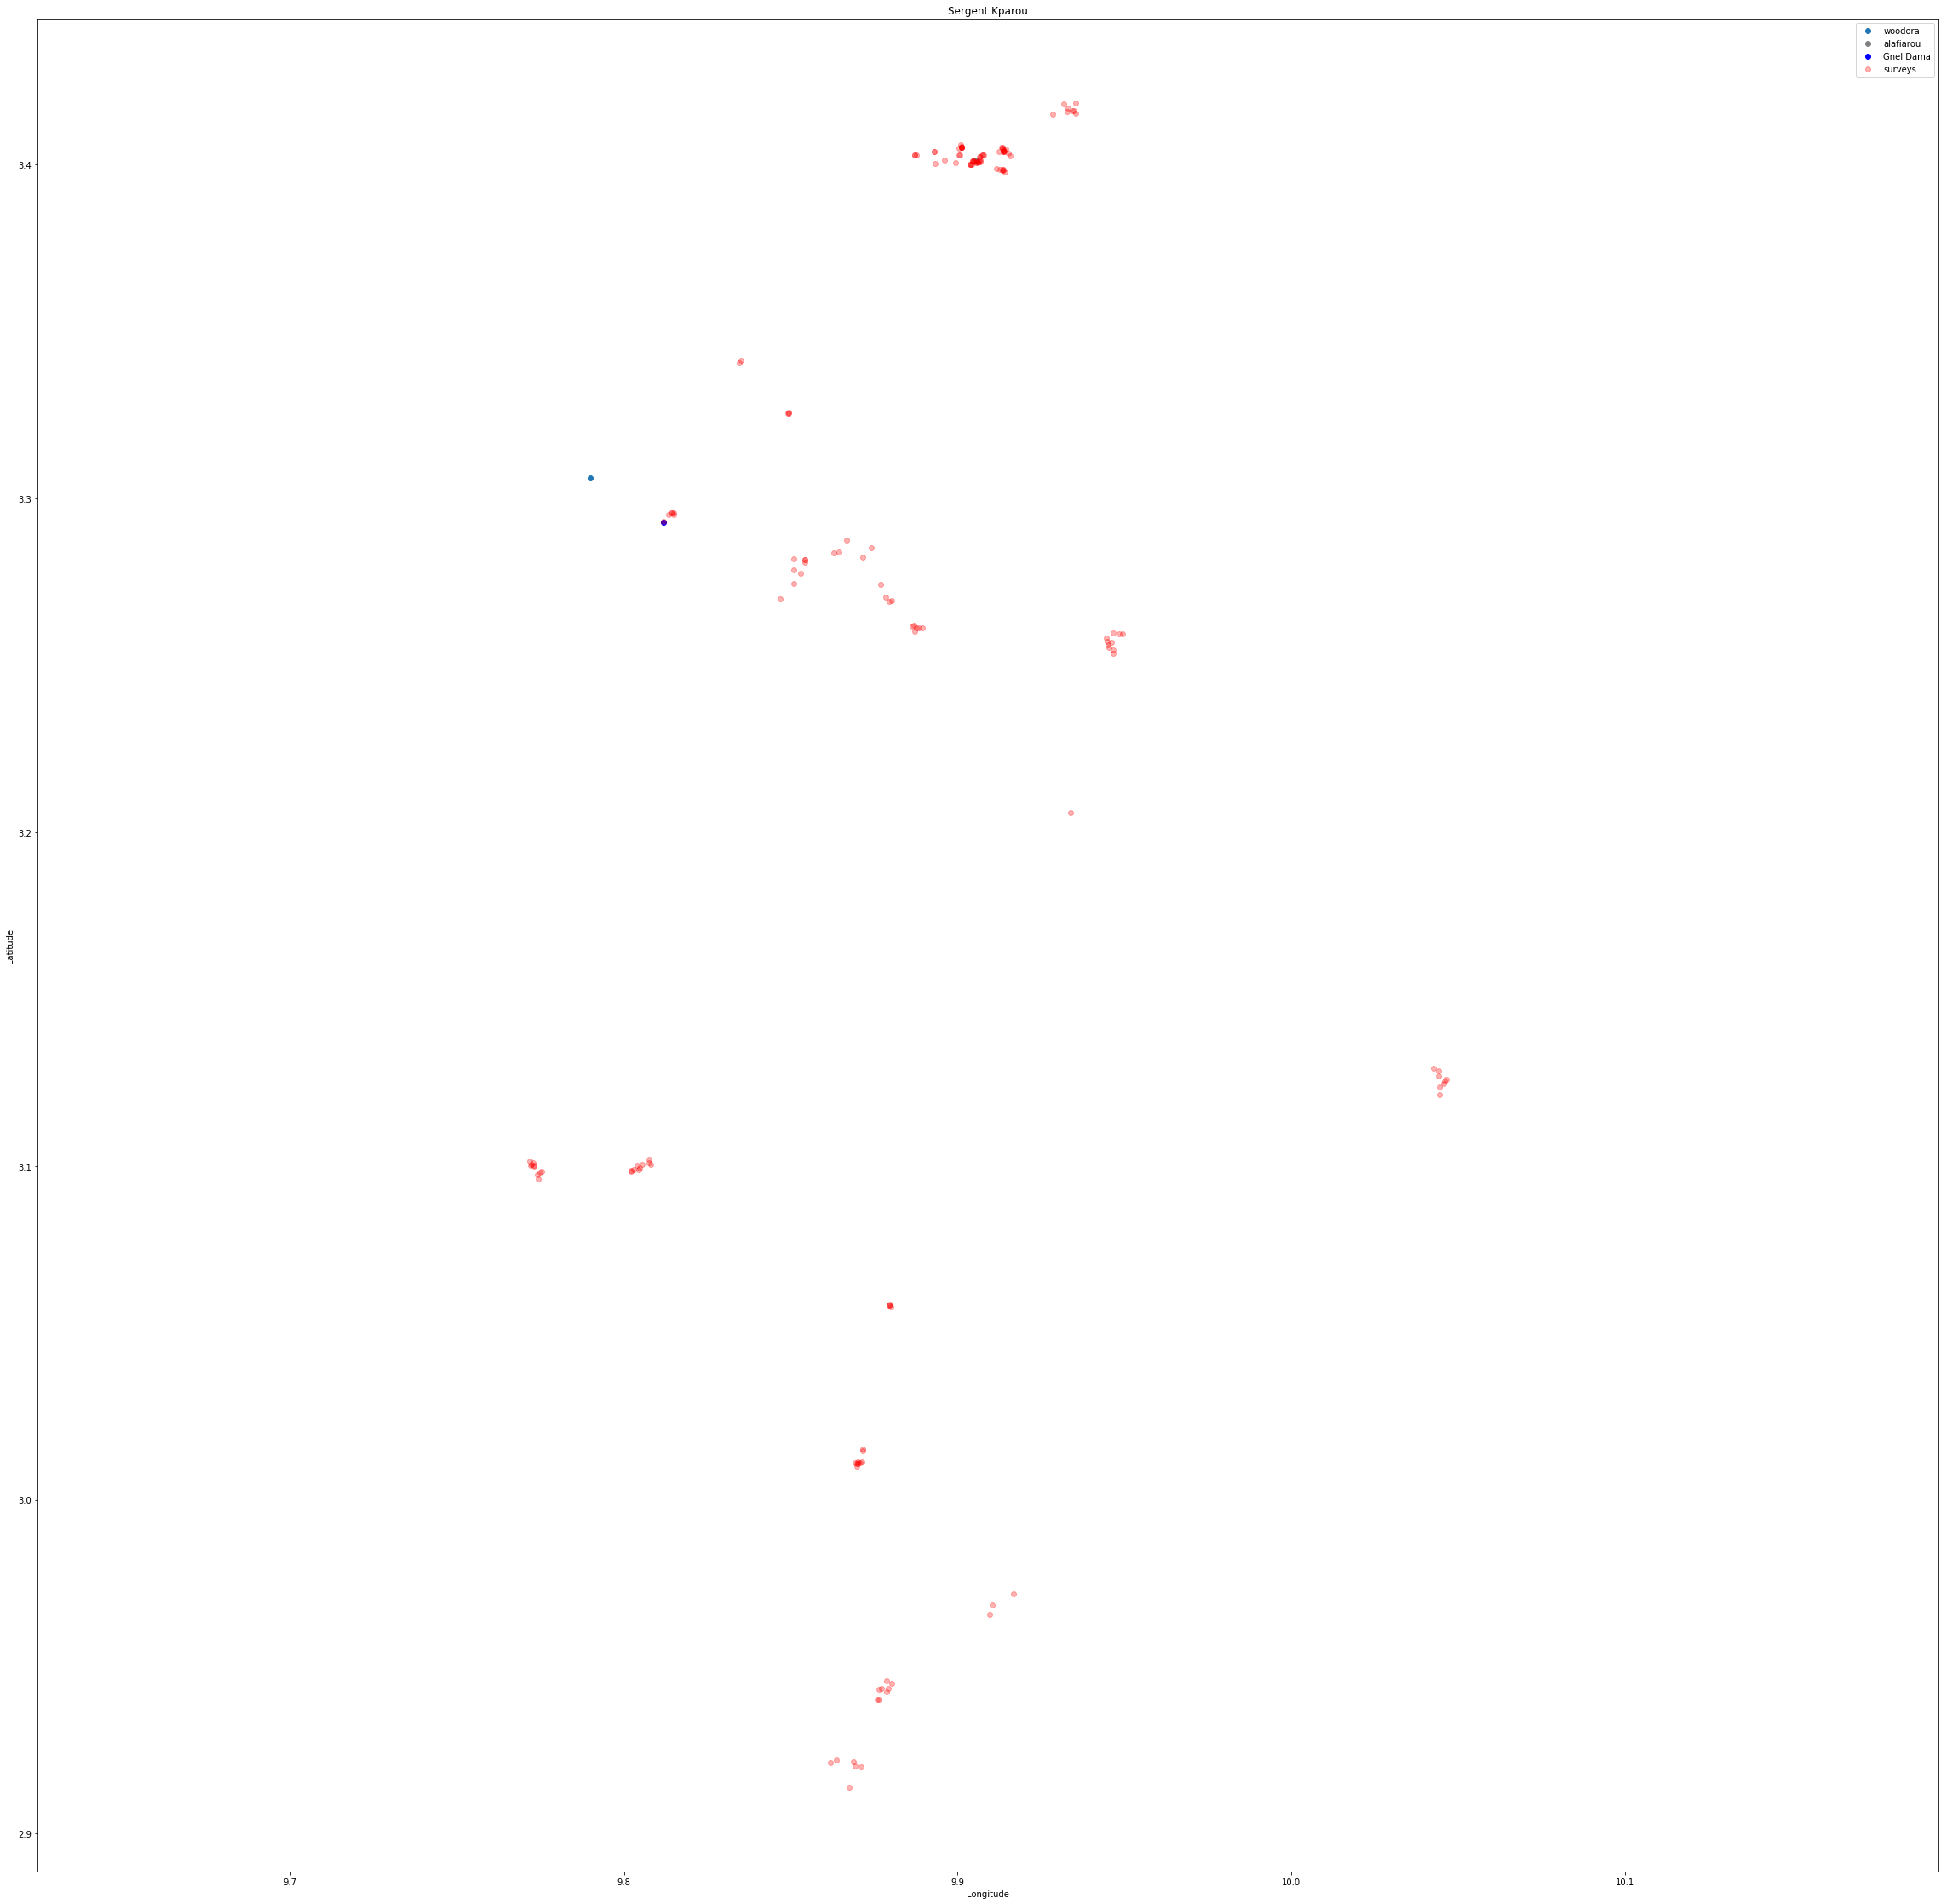

In [121]:

f,ax = plt.subplots(1,figsize=(40,40))
# Collect coords into list
coords = []

vil_coords=df_village[df_village['village_name']=='Wodora']['village_coords'].values[0]

vil_lat = float(vil_coords.split(' ;')[0])
vil_lon = float(vil_coords.split(' ;')[1])

coords.append([vil_lat,vil_lon])

X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',label='woodora')

coords = []

vil_coords=df_village[df_village['village_name']=='Alafiarou']['village_coords'].values[0]

vil_lat = float(vil_coords.split(' ;')[0])
vil_lon = float(vil_coords.split(' ;')[1])

coords.append([vil_lat,vil_lon])

X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='grey',label='alafiarou')

coords = []

vil_coords=df_village[df_village['village_name']=='GNEL DAMA']['village_coords'].values[0]

vil_lat = float(vil_coords.split(' ;')[0])
vil_lon = float(vil_coords.split(' ;')[1])

coords.append([vil_lat,vil_lon])

X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='blue',label='Gnel Dama')

coords = []

df_debbo=df_priority
for a,b in zip(df_debbo['longitude'].to_list(),df_debbo['latitude'].to_list()):
        coords.append((b, a))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o', alpha=0.3,color='red',label='surveys')


plt.title(village)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.legend()
plt.show()

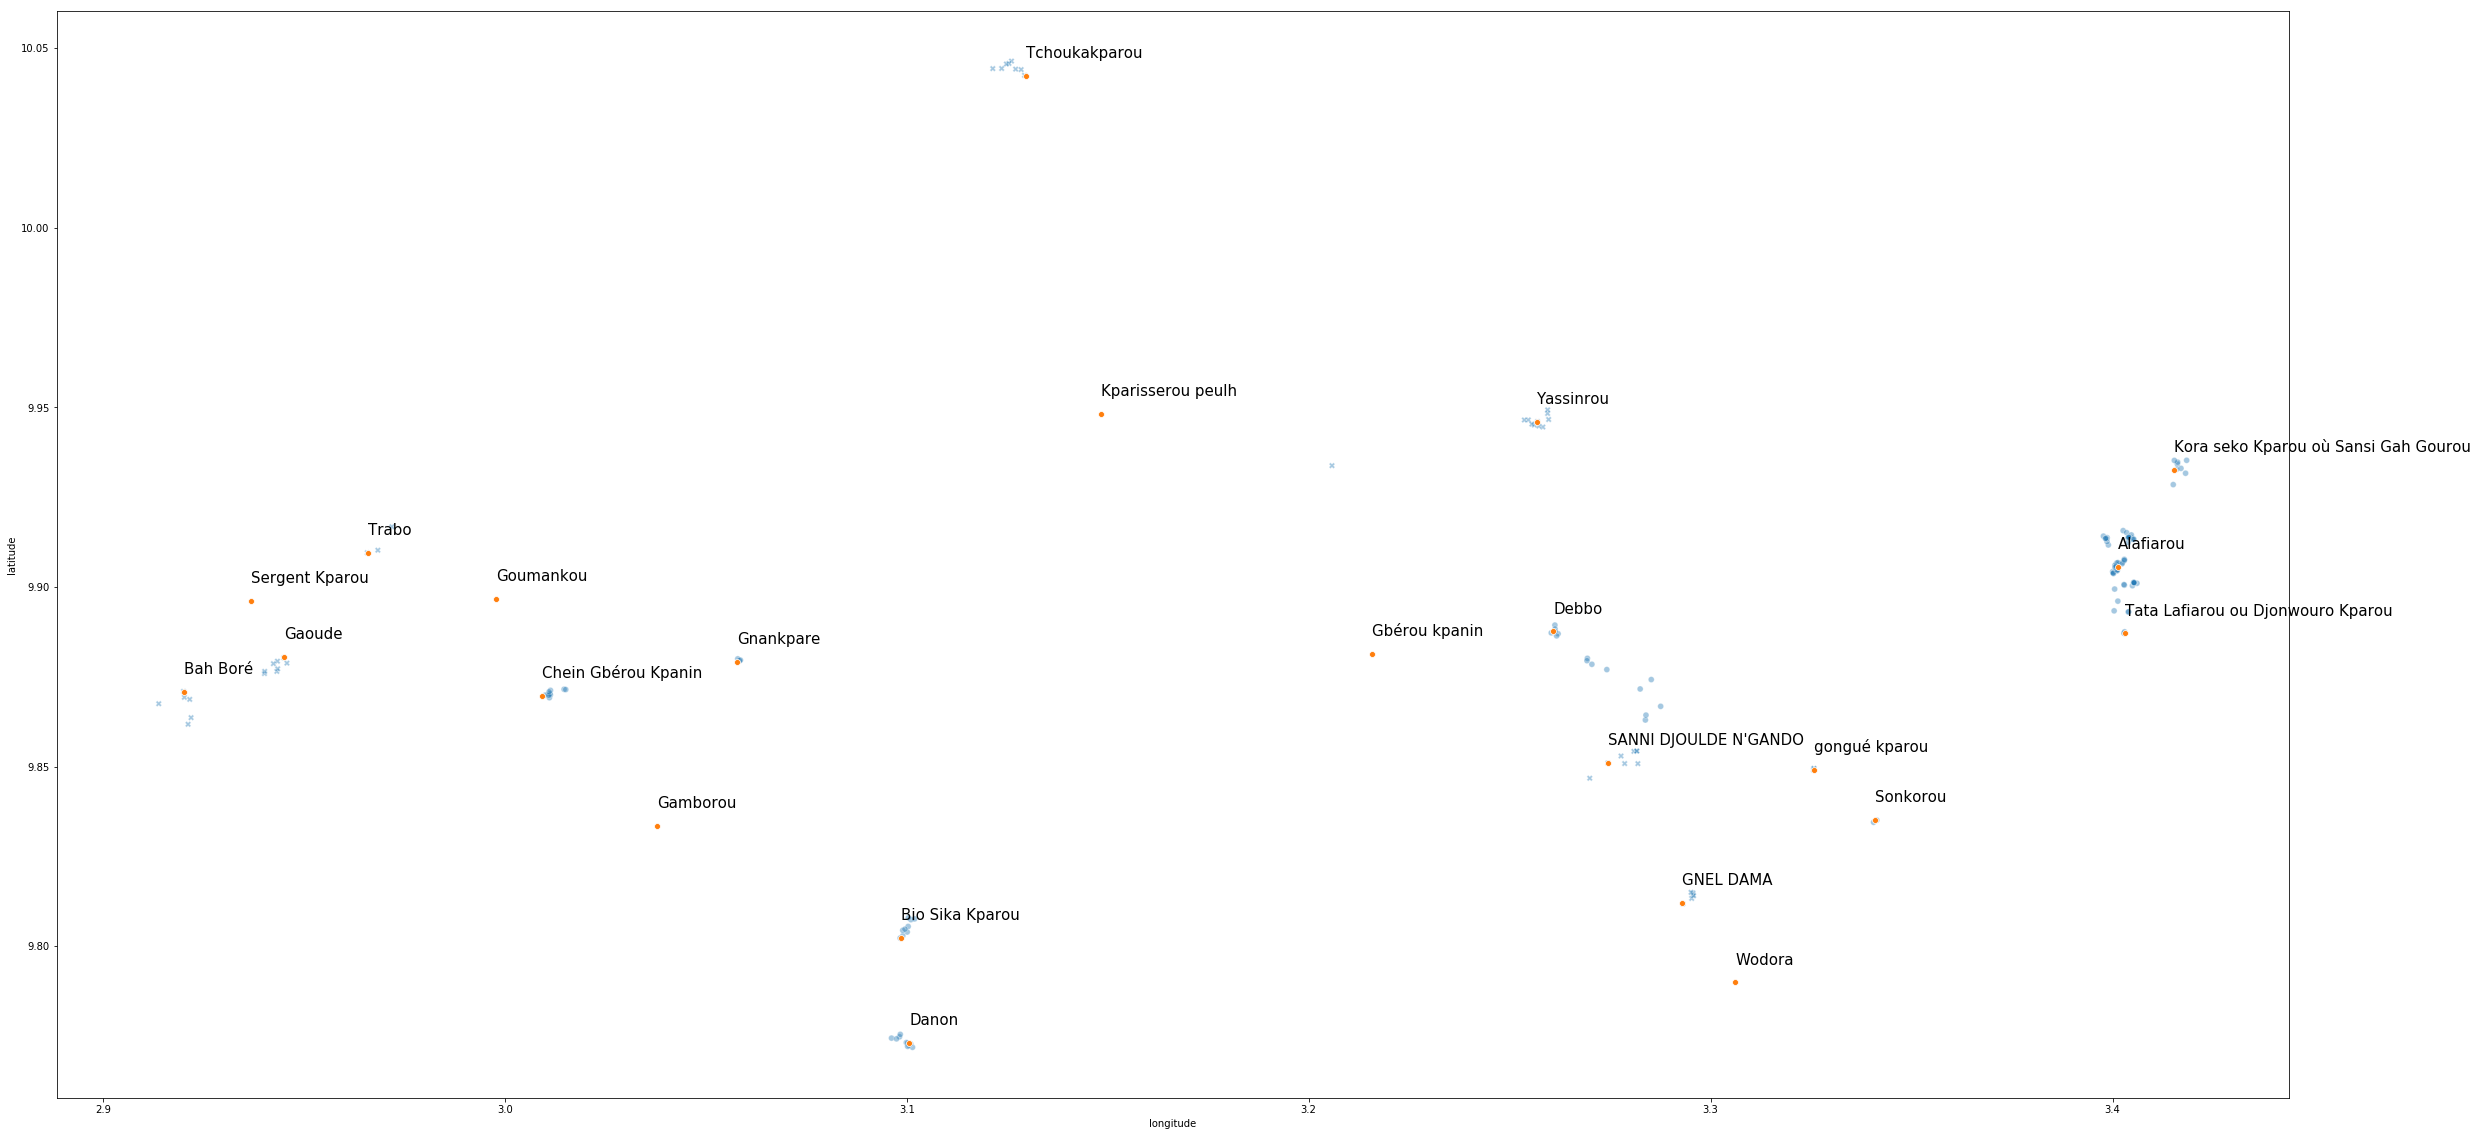

In [123]:
sns.scatterplot(y='latitude',x='longitude',style='source_name',alpha=0.4,data=df_priority)
p1=sns.scatterplot(y='latitude',x='longitude',palette='cubehelix',data=df_village)
for line in range(0,df_village.shape[0]):
     p1.text(df_village.longitude[line], 
             df_village.latitude[line]+0.005, 
             df_village.village_name[line], 
             horizontalalignment='left', 
             size='small', color='black',fontsize=15)

p1.get_legend().remove()
plt.rcParams['figure.figsize']=40,20

### REST OF ANALYSIS

In [208]:
df_priority['nb_people'] = pd.to_numeric(df_priority['nb_people'],errors='coerce')
df_priority['nb_diarrhoea'] = pd.to_numeric(df_priority['nb_diarrhoea'],errors='coerce')
df_priority['nb_malnu'] = pd.to_numeric(df_priority['nb_malnu'],errors='coerce')
df_priority['nb_basin'] = pd.to_numeric(df_priority['nb_basin'],errors='coerce')
df_priority['water_quality'] = pd.to_numeric(df_priority['water_quality'],errors='coerce')
df_priority['self_manag'] = pd.to_numeric(df_priority['self_manag'],errors='coerce')
df_priority['latitude'] = pd.to_numeric(df_priority['latitude'],errors='coerce')
df_priority['longitude'] = pd.to_numeric(df_priority['longitude'],errors='coerce')
df_priority.creation_date = pd.to_datetime(df_priority.creation_date)
df_priority.role = df_priority.role.astype(str)

In [209]:
df_priority['l_per']=df_priority['nb_basin']*25/df_priority['nb_people']

In [210]:
df_priority['t_diar']=df_priority['nb_diarrhoea']*100/df_priority['nb_people']

In [211]:
df_priority['t_mal']=df_priority['nb_malnu']*100/df_priority['nb_people']

In [212]:
df_priority['village'].unique()

array(['Alafiarou', 'Yassinrou', 'Kora seko Kparou où Sansi Gah Gourou',
       'Sonkorou', 'Tchoukakparou', 'Gaoude', 'Debbo',
       "SANNI DJOULDE N'GANDO", 'Gnankpare', 'gongué kparou',
       'Chein Gbérou Kpanin', 'Danon', 'Bah Boré', 'GNEL DAMA',
       'Tata Lafiarou ou Djonwouro Kparou ', 'Trabo', 'Bio Sika Kparou ',
       'Kparisserou peulh'], dtype=object)

In [213]:
df_priority.village = df_priority.village.astype(str)

In [214]:
df_priority.head()

,coords,latitude,longitude,creation_date,nb_basin,nb_people,nb_diarrhoea,nb_malnu,water_storage,water_quality,self_manag,role,village,source_name,dif_time,l_per,t_diar,t_mal
0,"{'altitudeAccuracy': None, 'accuracy': 9.80000...",9.914177,3.397727,2019-11-01 09:48:33.094000+00:00,9,20,2,0,null,1.0,4,FIRST WOMAN,Alafiarou,coords,1.702222,11.250000,10.000000,0.000000
1,"{'altitude': 452.1, 'longitude': 3.2561217, 'l...",9.945110,3.256122,2019-11-16 09:02:07.812000+00:00,17,18,5,1,NO,2.0,5,HEAD OF HOUSEHOLD [MALE],Yassinrou,vill,23.481667,23.611111,27.777778,5.555556
2,"{'longitude': 3.41592, 'latitude': 9.9327883, ...",9.932788,3.415920,2019-10-29 13:36:27.742000+00:00,99,83,3,2,NO,4.0,5,HEAD OF HOUSEHOLD [MALE],Kora seko Kparou où Sansi Gah Gourou,coords,23.249167,29.819277,3.614458,2.409639
3,"{'altitude': 507.7, 'longitude': 3.340545, 'la...",9.834493,3.340545,2019-11-04 09:27:28.400000+00:00,15,25,0,0,NO,2.0,4,HEAD OF HOUSEHOLD [MALE],Sonkorou,coords,22.635833,15.000000,0.000000,0.000000
4,"{'latitude': 9.9133667, 'altitudeAccuracy': No...",9.913367,3.404862,2019-11-01 08:36:33.269000+00:00,10,17,4,0,NO,3.0,4,HEAD OF HOUSEHOLD [MALE],Alafiarou,coords,2.902222,14.705882,23.529412,0.000000


In [215]:
df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'l_per':'mean',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    't_diar':'mean',
                                    't_mal':'mean',
                                    'creation_date':'count'
                            })

,nb_people,l_per,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,t_diar,t_mal,creation_date
village,,,,,,,,,,
Alafiarou,678,24.630128,138,6,567,1.961538,4.055556,21.758433,1.320547,54
Bah Boré,83,28.493320,20,0,92,2.000000,5.000000,22.957741,0.000000,6
Bio Sika Kparou,124,34.487431,43,0,153,2.100000,4.400000,32.006051,0.000000,10
Chein Gbérou Kpanin,111,37.799107,35,3,150,2.200000,3.800000,37.017857,3.428571,10
Danon,173,38.593967,34,3,158,2.500000,3.500000,24.690829,1.111111,10
Debbo,135,32.188358,26,2,160,2.000000,4.000000,18.449236,0.740741,10
GNEL DAMA,122,34.895353,20,0,135,1.666667,4.833333,20.587771,0.000000,6
Gaoude,119,33.836580,16,1,135,2.142857,5.000000,12.943723,0.649351,7
Gnankpare,92,27.240329,27,0,92,2.750000,4.250000,30.024731,0.000000,4


In [216]:
df_vill_analy=df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    'creation_date':'count'
                            }).reset_index()

In [217]:
df_vill_analy['l_per']=df_vill_analy['nb_basin']*25/df_vill_analy['nb_people']

In [218]:
df_vill_analy['t_diar']=df_vill_analy['nb_diarrhoea']*100/df_vill_analy['nb_people']

In [219]:
df_vill_analy['t_mal']=df_vill_analy['nb_malnu']*100/df_vill_analy['nb_people']

In [220]:
col_name=list(df_vill_analy.columns)
col_name[7]='n_enquetes'
df_vill_analy.columns=col_name

In [221]:
df_vill_analy

,village,nb_people,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,n_enquetes,l_per,t_diar,t_mal
0,Alafiarou,678,138,6,567,1.961538,4.055556,54,20.907080,20.353982,0.884956
1,Bah Boré,83,20,0,92,2.000000,5.000000,6,27.710843,24.096386,0.000000
2,Bio Sika Kparou,124,43,0,153,2.100000,4.400000,10,30.846774,34.677419,0.000000
3,Chein Gbérou Kpanin,111,35,3,150,2.200000,3.800000,10,33.783784,31.531532,2.702703
4,Danon,173,34,3,158,2.500000,3.500000,10,22.832370,19.653179,1.734104
5,Debbo,135,26,2,160,2.000000,4.000000,10,29.629630,19.259259,1.481481
6,GNEL DAMA,122,20,0,135,1.666667,4.833333,6,27.663934,16.393443,0.000000
7,Gaoude,119,16,1,135,2.142857,5.000000,7,28.361345,13.445378,0.840336
8,Gnankpare,92,27,0,92,2.750000,4.250000,4,25.000000,29.347826,0.000000
9,Kora seko Kparou où Sansi Gah Gourou,162,17,2,180,3.555556,4.888889,9,27.777778,10.493827,1.234568


## CONTAR CASAS DESDE OPENSTREETMAPS

In [432]:
village=[vil for vil in df_priority.village.unique()][9]
village

'Debbo'

In [433]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = ("""
[out:json];
area['name'='"""+str(village).upper()+
"""']->.a;
way[building](area.a);
(._;>;);
out body;
""")

overpass_query_2 = ("""
[out:json];
way['name'='"""+str(village).upper()+
"""'];
way(around:1000)[building];
(._;>;);
out body;
""")

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
#response_2 = requests.get(overpass_url, 
#                        params={'data': overpass_query_2})
data = response.json()
#data = response_2.json()

In [434]:
houses = []
ways=[elem for elem in data['elements']  if elem['type']=='way']
nodes=[elem for elem in data['elements']  if elem['type']=='node']
for way in ways:
    houses_info={}
    houses_info['id']=way['id']
    nodes_lats=[]
    nodes_longs=[]
    houses_info['nodes']=way['nodes']
    for node in nodes:
        if node['id'] in houses_info['nodes']:
            nodes_lats.append(node['lat'])
            nodes_longs.append(node['lon'])
    houses_info['lat']=np.mean(np.array(nodes_lats))
    houses_info['lon']=np.mean(np.array(nodes_longs))
    houses.append(houses_info)

In [435]:
df_houses=pd.DataFrame(houses)

In [436]:
len(df_houses)

39

In [437]:
df_houses['surveyed']=df_houses.apply(lambda x: has_been_survey(x),axis=1)

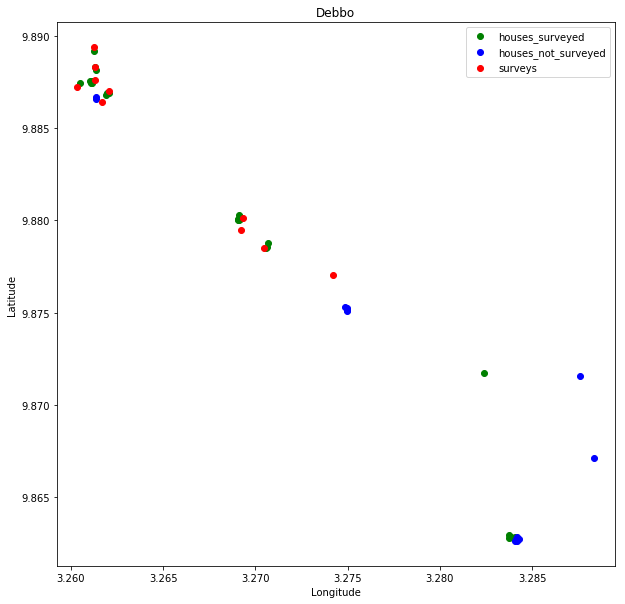

In [440]:

f,ax = plt.subplots(1,figsize=(10,10))
# Collect coords into list
coords = []

df_survey=df_houses[df_houses['surveyed']]
for a,b in zip(df_survey['lon'].to_list(),df_survey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='green',label='houses_surveyed')

coords = []
df_notsurvey=df_houses[~df_houses['surveyed']]
for a,b in zip(df_notsurvey['lon'].to_list(),df_notsurvey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='blue',label='houses_not_surveyed')

coords = []
df_debbo=df_priority[df_priority['village']==village]
for a,b in zip(df_debbo['longitude'].to_list(),df_debbo['latitude'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='red',label='surveys')


plt.title(village)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.legend()
plt.show()

# ESTIMACION DE LA POBLACION

In [254]:
df_priority['n_houses']=df_priority.apply(lambda x: n_houses(x),axis=1)

In [255]:
n_houses_surveyed=df_priority['n_houses'].sum()
n_houses_surveyed

12

In [256]:
n_people_belonging_to_houses=df_priority[df_priority['n_houses']!=0]['nb_people'].sum()
n_people_belonging_to_houses

134

In [257]:
n_total_houses=len(df_houses)
n_total_houses

15

In [258]:
#population estimate
n_people_belonging_to_houses*n_total_houses/n_houses_surveyed

167.5

In [259]:
#population in regards to survey
df_village[df_village['village_name']==village]

,village_coords,creation_date,nb_water_sources,heath_center,village_pop,village_name,water_sources,longitude,latitude,%_s_potable,close_vil
20,9.94608 ; 3.2569117,2019-11-16T08:31:02.742Z,3,Nikki,200,Yassinrou,"[{'ws_coords': '9.944615 ; 3.2581217', 'ws_com...",3.256912,9.94608,0.0,[]


## FOR ALL DATA

In [225]:
df_priority.village.unique()

array(['Alafiarou', 'Yassinrou', 'Kora seko Kparou où Sansi Gah Gourou',
       'Sonkorou', 'Tchoukakparou', 'Gaoude', 'Debbo',
       "SANNI DJOULDE N'GANDO", 'Gnankpare', 'gongué kparou',
       'Chein Gbérou Kpanin', 'Danon', 'Bah Boré', 'GNEL DAMA',
       'Tata Lafiarou ou Djonwouro Kparou ', 'Trabo', 'Bio Sika Kparou ',
       'Kparisserou peulh'], dtype=object)

In [226]:
df_priority[df_priority['village']=="gongué kparou"].head(5)

,village_coords,latitude,longitude,creation_date,nb_basin,nb_people,nb_diarrhoea,nb_malnu,water_storage,water_quality,self_manag,role,village,source_name,dif_time,l_per,t_diar,t_mal
18,"{'latitude': 9.8490583, 'altitudeAccuracy': No...",9.849058,3.325597,2019-11-21 16:34:13.762000+00:00,8,6,0,0,NO,1.0,5,FIRST WOMAN,gongué kparou,vill,23.900833,33.333333,0.000000,0.0
55,"{'altitude': 463.7, 'longitude': 3.3256367, 'l...",9.849460,3.325637,2019-11-21 15:55:21.904000+00:00,14,7,2,0,NO,2.0,5,ANOTHER MALE,gongué kparou,vill,0.548611,50.000000,28.571429,0.0
56,"{'altitude': 461.7, 'longitude': 3.3257433, 'l...",9.849478,3.325743,2019-11-21 16:03:35.683000+00:00,15,11,0,0,NO,4.0,5,FIRST WOMAN,gongué kparou,vill,0.411389,34.090909,0.000000,0.0


In [227]:
village_translate={
    'Alafiarou':'ALAFIAROU',
    'Sonkorou':'SONKOROU',
    'Kora seko Kparou où Sansi Gah Gourou':'KORA SEKO KPAROU - SANSI GAH GOUNOU',
    'Debbo':'DEBBO',
    'Danon':'DANON Gando',
    'Gbérou kpanin':'GBÉROU KPANIN',
    'Wodora':'WODORA',
    'Tata Lafiarou ou Djonwouro Kparou ':'DJONWOURA KPAROU',
    'Gnankpare':'GNANKPARE',
    'Bio Sika Kparou ':'BIO SIKA KPAROU',
    'Chein Gbérou Kpanin':'GAH SONA',
    'Yassinrou':'YASSINROU',
    'Tchoukakparou':'TCHOUKAKPAROU',
    "SANNI DJOULDE N'GANDO":"SANNI DJOULDE N´GANDO",
    "GNEL DAMA":"GNEL DAMA",
    "Gongué kparou":"GONGUÉ KPAROU",
    "gongué kparou":"GONGUÉ KPAROU",
    "Trabo":"TRABO",
    "Kparisserou peulh":"GAH MARO PEULH",
    "Gaoude":"GAOUDE",
    "Bah Boré":"BAH BORÉ"
    
    
}

In [228]:
for vill in village_translate.keys():
    if not vill in df_priority.village.unique():
        print(vill)

Gbérou kpanin
Wodora
Gongué kparou


In [229]:
for vill in df_priority.village.unique():
    if not vill in village_translate:
        print(vill)

In [230]:
villages=[vil for vil in df_priority.village.sort_values().unique()]
villages.remove('Kparisserou peulh')
pop_est={}
vil_house_data={}
for vil in villages:
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = ("""
    [out:json];
    area['name'='"""+village_translate[vil]+
    """']->.a;
    way[building](area.a);
    (._;>;);
    out body;
    """)

    response = requests.get(overpass_url, 
                            params={'data': overpass_query})

    data = response.json()
    houses = []
    
    ways=[elem for elem in data['elements']  if elem['type']=='way']
    nodes=[elem for elem in data['elements']  if elem['type']=='node']
    
    for way in ways:
        houses_info={}
        houses_info['id']=way['id']
        nodes_lats=[]
        nodes_longs=[]
        houses_info['nodes']=way['nodes']
        for node in nodes:
            if node['id'] in houses_info['nodes']:
                nodes_lats.append(node['lat'])
                nodes_longs.append(node['lon'])
        houses_info['lat']=np.mean(np.array(nodes_lats))
        houses_info['lon']=np.mean(np.array(nodes_longs))
        houses.append(houses_info)
        
    df_houses=pd.DataFrame(houses)
    
    print(vil,len(df_houses))
    df_houses['surveyed']=df_houses.apply(lambda x: has_been_survey(x),axis=1)
    df_priority['n_houses']=df_priority.apply(lambda x: n_houses(x),axis=1)
    df_vil=df_priority[df_priority['village']==vil]
    n_houses_surveyed=df_vil['n_houses'].sum()
    n_people_belonging_to_houses=df_vil[df_vil['n_houses']!=0]['nb_people'].sum()
    n_total_houses=len(df_houses)
    pop_est[vil]=n_people_belonging_to_houses*n_total_houses/n_houses_surveyed
    vil_house_data[vil]=df_houses.to_dict()
    time.sleep(6)

Alafiarou 114
Bah Boré 24
Bio Sika Kparou  21
Chein Gbérou Kpanin 25
Danon 55
Debbo 39
GNEL DAMA 12
Gaoude 20
Gnankpare 18
Kora seko Kparou où Sansi Gah Gourou 65
SANNI DJOULDE N'GANDO 25
Sonkorou 22
Tata Lafiarou ou Djonwouro Kparou  6
Tchoukakparou 13
Trabo 7
Yassinrou 15
gongué kparou 13


In [231]:
df_vill_analy

,village,nb_people,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,n_enquetes,l_per,t_diar,t_mal
0,Alafiarou,678,138,6,567,1.961538,4.055556,54,20.907080,20.353982,0.884956
1,Bah Boré,83,20,0,92,2.000000,5.000000,6,27.710843,24.096386,0.000000
2,Bio Sika Kparou,124,43,0,153,2.100000,4.400000,10,30.846774,34.677419,0.000000
3,Chein Gbérou Kpanin,111,35,3,150,2.200000,3.800000,10,33.783784,31.531532,2.702703
4,Danon,173,34,3,158,2.500000,3.500000,10,22.832370,19.653179,1.734104
5,Debbo,135,26,2,160,2.000000,4.000000,10,29.629630,19.259259,1.481481
6,GNEL DAMA,122,20,0,135,1.666667,4.833333,6,27.663934,16.393443,0.000000
7,Gaoude,119,16,1,135,2.142857,5.000000,7,28.361345,13.445378,0.840336
8,Gnankpare,92,27,0,92,2.750000,4.250000,4,25.000000,29.347826,0.000000
9,Kora seko Kparou où Sansi Gah Gourou,162,17,2,180,3.555556,4.888889,9,27.777778,10.493827,1.234568


In [232]:
df_vill_analy=df_vill_analy.drop(df_vill_analy[df_vill_analy['village']=='Kparisserou peulh'].index[0])

In [233]:
df_vill_analy=df_vill_analy.reset_index().drop('index',axis=1)

In [234]:
df_vill_analy[['house_data','pop_est']]=df_vill_analy.apply(lambda x: pd.Series([
                                        vil_house_data[x['village']],
                                        pop_est[x['village']]
                                            ]),axis=1)

In [235]:
df_vil_final=pd.merge(df_village,df_vill_analy,left_on='village_name',right_on='village',how='inner')

In [236]:
df_vil_final.columns

Index(['village_coords', 'creation_date', 'nb_water_sources', 'heath_center',
       'village_pop', 'village_name', 'water_sources', 'longitude', 'latitude',
       '%_s_potable', 'close_vil', 'village', 'nb_people', 'nb_diarrhoea',
       'nb_malnu', 'nb_basin', 'water_quality', 'self_manag', 'n_enquetes',
       'l_per', 't_diar', 't_mal', 'house_data', 'pop_est'],
      dtype='object')

### MERGE DATA of surveys to village

In [238]:
df_priority.columns = ['village_coords','latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'village','source_name','dif_time','l_per', 't_diar', 't_mal', 
       'n_houses']

In [239]:
surv=df_priority[['village','t_diar','l_per']].to_dict('index')
surv_dict = [{k: v} for k, v in surv.items()]

In [240]:
def addsurv(x):
    surveys =[]
    for i,a in enumerate(surv_dict):
        if a[i]['village']==x['village_name']:
            surveys.append(a[i])
            
    return surveys

In [241]:
df_vil_final['surveys']=df_vil_final.apply(lambda x: addsurv(x), axis=1)

In [242]:
df_vil_final=df_vil_final.fillna('nan')

In [171]:
df_vil_final.columns

Index(['village_coords', 'creation_date', 'nb_water_sources', 'heath_center',
       'village_pop', 'village_name', 'water_sources', 'longitude', 'latitude',
       '%_s_potable', 'close_vil', 'village', 'nb_people', 'nb_diarrhoea',
       'nb_malnu', 'nb_basin', 'water_quality', 'self_manag', 'n_enquetes',
       'l_per', 't_diar', 't_mal', 'house_data', 'pop_est', 'surveys'],
      dtype='object')

## CALCULATE IMPACT

In [382]:
def cal_impact(x):
    vil_pop=x['village_pop']
    if vil_pop == 'null' or vil_pop=='nan':
        pop = float(x['pop_est'])
    else:
        pop=float(np.mean([float(vil_pop),float(x['pop_est'])]))
        
    q_stock = float(x['water_quality'])
    c_aut = float(x['self_manag'])
    t_diar = float(x['t_diar'])
    l_per = float(x['l_per'])
    p = float(110-x['%_s_potable'])/100
    f = 0.05
    
    impact = pop*(t_diar/100)*(50-l_per)/sqrt(l_per)*p**2*f*((0.6*q_stock+0.4*c_aut)/5)
    
    return impact
    

In [383]:
def cal_score(x):
    impacts=np.array(df_vil_final.impact.to_list())
    
    prior_score=1-((np.max(impacts)-x['impact'])/(np.max(impacts)-np.min(impacts)))
    
    return prior_score

In [384]:
df_vil_final['impact'] = df_vil_final.apply(lambda x: cal_impact(x),axis=1)

In [385]:
df_vil_final['prior_score'] = df_vil_final.apply(lambda x: cal_score(x),axis=1)

In [386]:
df_vil_final=df_vil_final.sort_values(by='prior_score',ascending=False).reset_index().drop('index',axis=1)

In [387]:
df_vil_final[['village_pop','pop_est','village_name',
              '%_s_potable','self_manag','water_quality',
              'n_enquetes','l_per','t_diar',
              'impact','prior_score'
             ]]

,village_pop,pop_est,village_name,%_s_potable,self_manag,water_quality,n_enquetes,l_per,t_diar,impact,prior_score
0,150,238.888889,SANNI DJOULDE N'GANDO,0.000000,4.307692,2.153846,13,22.821970,21.969697,8.867253,1.000000
1,200,165.375000,Bio Sika Kparou,0.000000,4.400000,2.100000,10,30.846774,34.677419,7.983346,0.898797
2,200,146.900000,Tchoukakparou,0.000000,5.000000,2.250000,8,24.223602,21.118012,7.776074,0.875066
3,200,167.500000,Yassinrou,0.000000,4.900000,2.000000,10,25.862069,20.114943,6.707907,0.752766
4,150,63.692308,Gnankpare,0.000000,4.250000,2.750000,4,25.000000,29.347826,6.355285,0.712392
5,300,60.483871,Chein Gbérou Kpanin,0.000000,3.800000,2.200000,10,33.783784,31.531532,5.448789,0.608603
6,150,94.857143,Bah Boré,0.000000,5.000000,2.000000,6,27.710843,24.096386,4.836585,0.538509
7,150,174.000000,Gaoude,0.000000,5.000000,2.142857,7,28.361345,13.445378,3.518601,0.387607
8,150,122.000000,GNEL DAMA,0.000000,4.833333,1.666667,6,27.663934,16.393443,3.360513,0.369506
9,350,501.944444,Kora seko Kparou où Sansi Gah Gourou,50.000000,4.888889,3.555556,9,27.777778,10.493827,2.774353,0.302394


## some checks

In [521]:
df_vil_final['cal_wat']=df_vil_final['%_s_potable']*df_vil_final['water_quality']*df_vil_final['l_per']

In [522]:
df_vil_final['cal_wat']=pd.to_numeric(df_vil_final['cal_wat'],errors='coerce')

In [523]:
df_vil_final['prior_score']=pd.to_numeric(df_vil_final['prior_score'],errors='coerce')

In [524]:
df_vil_final['village_pop']=pd.to_numeric(df_vil_final['village_pop'],errors='coerce')

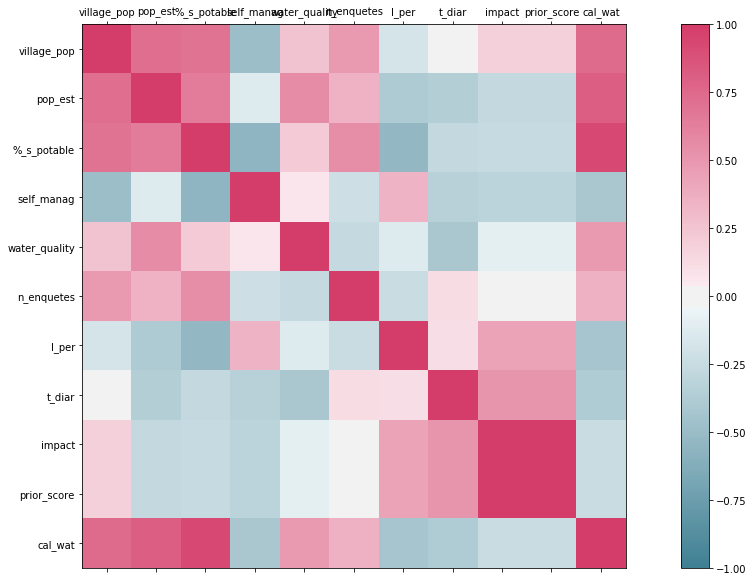

In [462]:
df_correlations =  df_vil_final[['village_pop','pop_est',
              '%_s_potable','self_manag','water_quality',
              'n_enquetes','l_per','t_diar',
              'impact','prior_score','cal_wat'
             ]]
names=df_correlations.columns
correlations = df_correlations.corr()
# plot correlation matrix
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, cmap=sns.diverging_palette(220, 0, as_cmap=True), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [463]:
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

,village_pop,pop_est,%_s_potable,self_manag,water_quality,n_enquetes,l_per,t_diar,impact,prior_score,cal_wat
village_pop,1,0.73,0.7,-0.49,0.26,0.48,-0.18,-0.025,0.19,0.19,0.74
pop_est,0.73,1,0.64,-0.13,0.56,0.34,-0.38,-0.35,-0.27,-0.27,0.81
%_s_potable,0.7,0.64,1,-0.56,0.21,0.54,-0.54,-0.27,-0.25,-0.25,0.93
self_manag,-0.49,-0.13,-0.56,1,0.066,-0.21,0.34,-0.33,-0.31,-0.31,-0.41
water_quality,0.26,0.56,0.21,0.066,1,-0.26,-0.13,-0.41,-0.092,-0.092,0.48
n_enquetes,0.48,0.34,0.54,-0.21,-0.26,1,-0.25,0.12,-0.029,-0.029,0.35
l_per,-0.18,-0.38,-0.54,0.34,-0.13,-0.25,1,0.11,0.43,0.43,-0.43
t_diar,-0.025,-0.35,-0.27,-0.33,-0.41,0.12,0.11,1,0.51,0.51,-0.38
impact,0.19,-0.27,-0.25,-0.31,-0.092,-0.029,0.43,0.51,1,1,-0.25
prior_score,0.19,-0.27,-0.25,-0.31,-0.092,-0.029,0.43,0.51,1,1,-0.25


## PUBLISH DATA TO FIREBASE

### VILLAGE

In [388]:
df_to_up = df_vil_final[['village_name','village_coords',
                         'nb_water_sources','%_s_potable',
                         'village_pop','pop_est',
                         'surveys','n_enquetes',
                         'self_manag','water_quality',
                         'impact','prior_score',
                         'l_per','t_diar'
                        ]]

df_to_up.columns =['village_name','village_coords',
                         'nb_water_sources','perc_s_potable',
                         'village_pop','pop_est',
                         'surveys','n_enquetes',
                         'self_manag','water_quality',
                         'impact','prior_score',
                         'l_per','t_diar'
                        ]

In [389]:
#convert info to upload to firebase... housedata needs more treatment to be uplo
vil_prior = df_to_up.to_dict('index')
vil_prior_dict = [{k: v} for k, v in vil_prior.items()] 
vil_prior_l_dict = []
for vil in vil_prior_dict:
    id_vil=list(vil.keys())[0]
    vil_info=vil[id_vil]
    new_data=vil_info
  
    doc_vil = db.collection(u'priority').add(new_data)[1]
    vil_id = doc_vil.id
    doc_vil.update({'id':vil_id})
    vil_prior_l_dict.append(new_data)

## PUBLISH DATA TO BIGQUERY

In [116]:
import pandas_gbq
import unidecode

from google.cloud import bigquery
import os

In [117]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/Users/5danalfaro/OAN/credentials/OAN Gestion Eau-b067bbf8dde1.json'

In [118]:
client = bigquery.Client()

## create dataset

In [121]:
# TODO(developer): Set dataset_id to the ID of the dataset to create.
dataset_id = "{}.priority_data".format(client.project)

# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset(dataset_id)

# TODO(developer): Specify thaae geographic location where the dataset should reside.
dataset.location = "EU"

In [72]:
# Send the dataset to the API for creation.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
dataset = client.create_dataset(dataset)  # API request
print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

Created dataset oan-gestion-eau.priority_data


In [122]:
"{}.{}".format(client.project, dataset.dataset_id)

'oan-gestion-eau.priority_data'

In [110]:
bq_tr_typ={'float64':'FLOAT64',
           'int64':'INT64',
           'datetime64[ns, UTC]':'DATETIME',
           'object':'STRING'}

## create table for priority survey

In [127]:
df_priority.columns = ['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l_per', 't_diar', 't_mal', 'village',
       'n_houses']

In [128]:
schema = [bigquery.SchemaField(ind,bq_tr_typ[str(typ)]) 
          for ind,typ in zip(df_priority.dtypes.index.to_list(),df_priority.dtypes.to_list())]

In [129]:
# TODO(developer): Construct a BigQuery client object.
# client = bigquery.Client()

# TODO(developer): Set table_id to the ID of the table to create
table_id = "{}.{}.priority_surveys".format(client.project, dataset.dataset_id)

table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table)  # API request
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table oan-gestion-eau.priority_data.priority_surveys


In [131]:
table_id_pd = "{}.priority_surveys".format(dataset.dataset_id)

In [132]:
pandas_gbq.to_gbq(df_priority, table_id_pd, project_id=client.project, if_exists='replace')

1it [00:13, 13.76s/it]


## create table for village info

In [135]:
df_vil_final.columns = ['village_coords', 'creation_date', 'nb_water_sources', 'heath_center',
       'village_pop', 'village_name', 'water_sources', 'longitude', 'latitude',
       'perc_s_potable', 'village', 'nb_people', 'nb_diarrhoea', 'nb_malnu',
       'nb_basin', 'water_quality', 'self_manag', 'n_enquetes', 'l_per',
       't_diar', 't_mal', 'house_data', 'pop_est']

In [141]:
df_vil_final_to_up=df_vil_final[['creation_date', 'nb_water_sources', 'heath_center',
       'village_pop', 'village_name', 'water_sources', 'longitude', 'latitude',
       'perc_s_potable', 'nb_people', 'water_quality', 'self_manag', 'n_enquetes', 'l_per',
       't_diar', 't_mal', 'pop_est']].copy()

In [146]:
df_vil_final_to_up.longitude = pd.to_numeric(df_vil_final_to_up.longitude,errors='coerce')
df_vil_final_to_up.latitude = pd.to_numeric(df_vil_final_to_up.latitude,errors='coerce')
df_vil_final_to_up.creation_date = pd.to_datetime(df_vil_final_to_up.creation_date)
df_vil_final_to_up.nb_water_sources = pd.to_numeric(df_vil_final_to_up.nb_water_sources,errors='coerce')

df_vil_final_to_up.heath_center = df_vil_final_to_up.heath_center.astype(str)

df_vil_final_to_up.village_pop = pd.to_numeric(df_vil_final_to_up.village_pop,errors='coerce')

df_vil_final_to_up.village_name = df_vil_final_to_up.village_name.astype(str)
df_vil_final_to_up.perc_s_potable = pd.to_numeric(df_vil_final_to_up.perc_s_potable,errors='coerce')

df_vil_final_to_up.nb_people = pd.to_numeric(df_vil_final_to_up.nb_people,errors='coerce')

df_vil_final_to_up.water_quality = pd.to_numeric(df_vil_final_to_up.water_quality,errors='coerce')

df_vil_final_to_up.self_manag = pd.to_numeric(df_vil_final_to_up.self_manag,errors='coerce')


df_vil_final_to_up.n_enquetes = pd.to_numeric(df_vil_final_to_up.n_enquetes,errors='coerce')



In [149]:
schema = [bigquery.SchemaField(ind,bq_tr_typ[str(typ)]) 
          for ind,typ in zip(df_vil_final_to_up.dtypes.index.to_list(),df_vil_final_to_up.dtypes.to_list())]


In [150]:
# TODO(developer): Construct a BigQuery client object.
# client = bigquery.Client()

# TODO(developer): Set table_id to the ID of the table to create
table_id = "{}.{}.village_data".format(client.project, dataset.dataset_id)

table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table)  # API request
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table oan-gestion-eau.priority_data.village_data


In [151]:
table_id_pd = "{}.village_data".format(dataset.dataset_id)

In [152]:
pandas_gbq.to_gbq(df_vil_final_to_up, table_id_pd, project_id=client.project, if_exists='replace')

1it [00:12, 12.80s/it]


### FALCOM SQL CLIENT

#### connected to falcom to publish tables
<iframe width="900" height="800" frameborder="0" scrolling="no" src="//plot.ly/~5danalfaro/9.embed"></iframe>

In [155]:
client.project

'oan-gestion-eau'

In [156]:
table_id_pd

'priority_data.village_data'

### VISUALIZE DATA

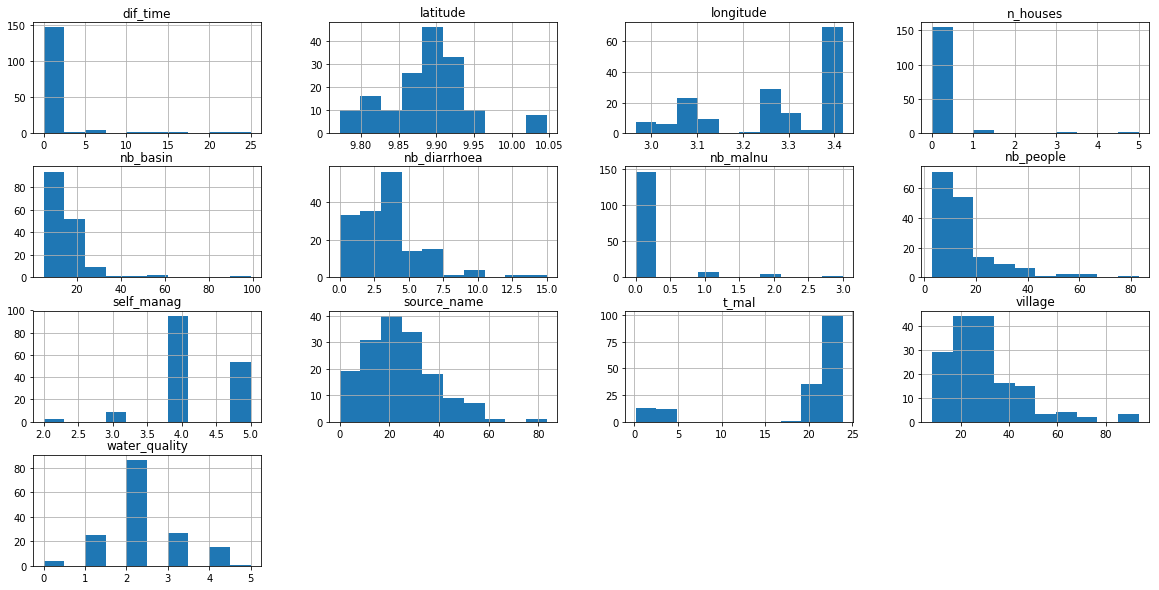

In [386]:
df_priority.hist(figsize=(20,10))
plt.show()

In [36]:
df_priority.columns

Index(['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l/per', 't_diar', 't_mal', 'village'],
      dtype='object')

In [397]:
df_priority[['nb_people','l_per','t_diar',
                               't_mal','water_quality','self_manag']].dtypes

nb_people          int64
l_per            float64
t_diar           float64
t_mal            float64
water_quality    float64
self_manag         int64
dtype: object

In [398]:
df_priority.l_per = pd.to_numeric(df_priority.l_per, errors='coerce')

In [399]:
df_priority.t_diar = pd.to_numeric(df_priority.t_diar, errors='coerce')

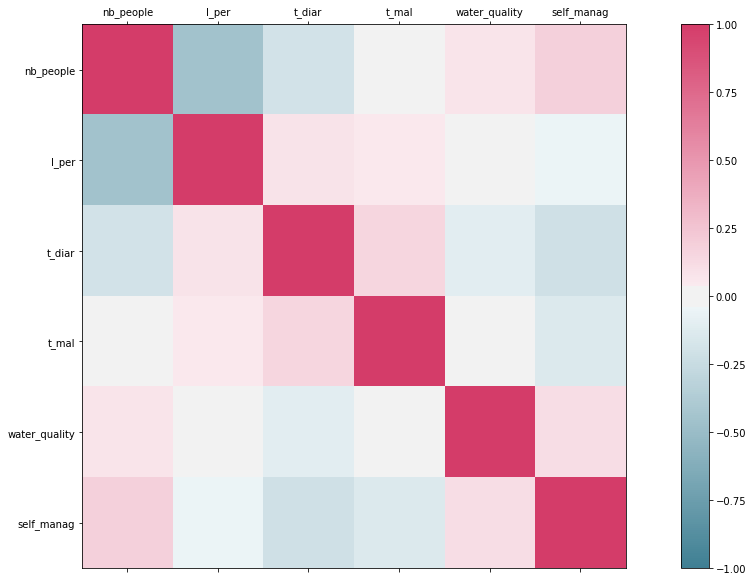

In [455]:
df_correlations = df_priority[['nb_people','l_per','t_diar',
                               't_mal','water_quality','self_manag']]
names=df_correlations.columns
correlations = df_correlations.corr()
# plot correlation matrix
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, cmap=sns.diverging_palette(220, 0, as_cmap=True), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [456]:
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

,nb_people,l_per,t_diar,t_mal,water_quality,self_manag
nb_people,1,-0.45,-0.19,-0.03,0.072,0.19
l_per,-0.45,1,0.079,0.047,0.032,-0.052
t_diar,-0.19,0.079,1,0.15,-0.11,-0.21
t_mal,-0.03,0.047,0.15,1,0.019,-0.14
water_quality,0.072,0.032,-0.11,0.019,1,0.11
self_manag,0.19,-0.052,-0.21,-0.14,0.11,1


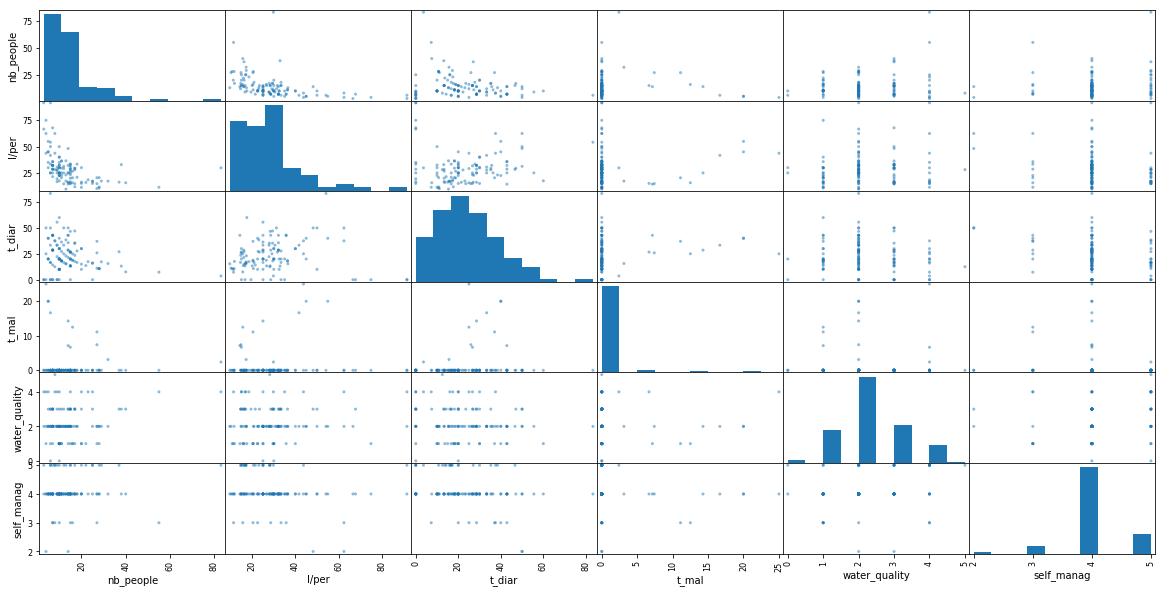

In [39]:
scatter_matrix(df_correlations,figsize=(20,10))
plt.show()

In [45]:
df_priority.columns

Index(['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l/per', 't_diar', 't_mal', 'village'],
      dtype='object')

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


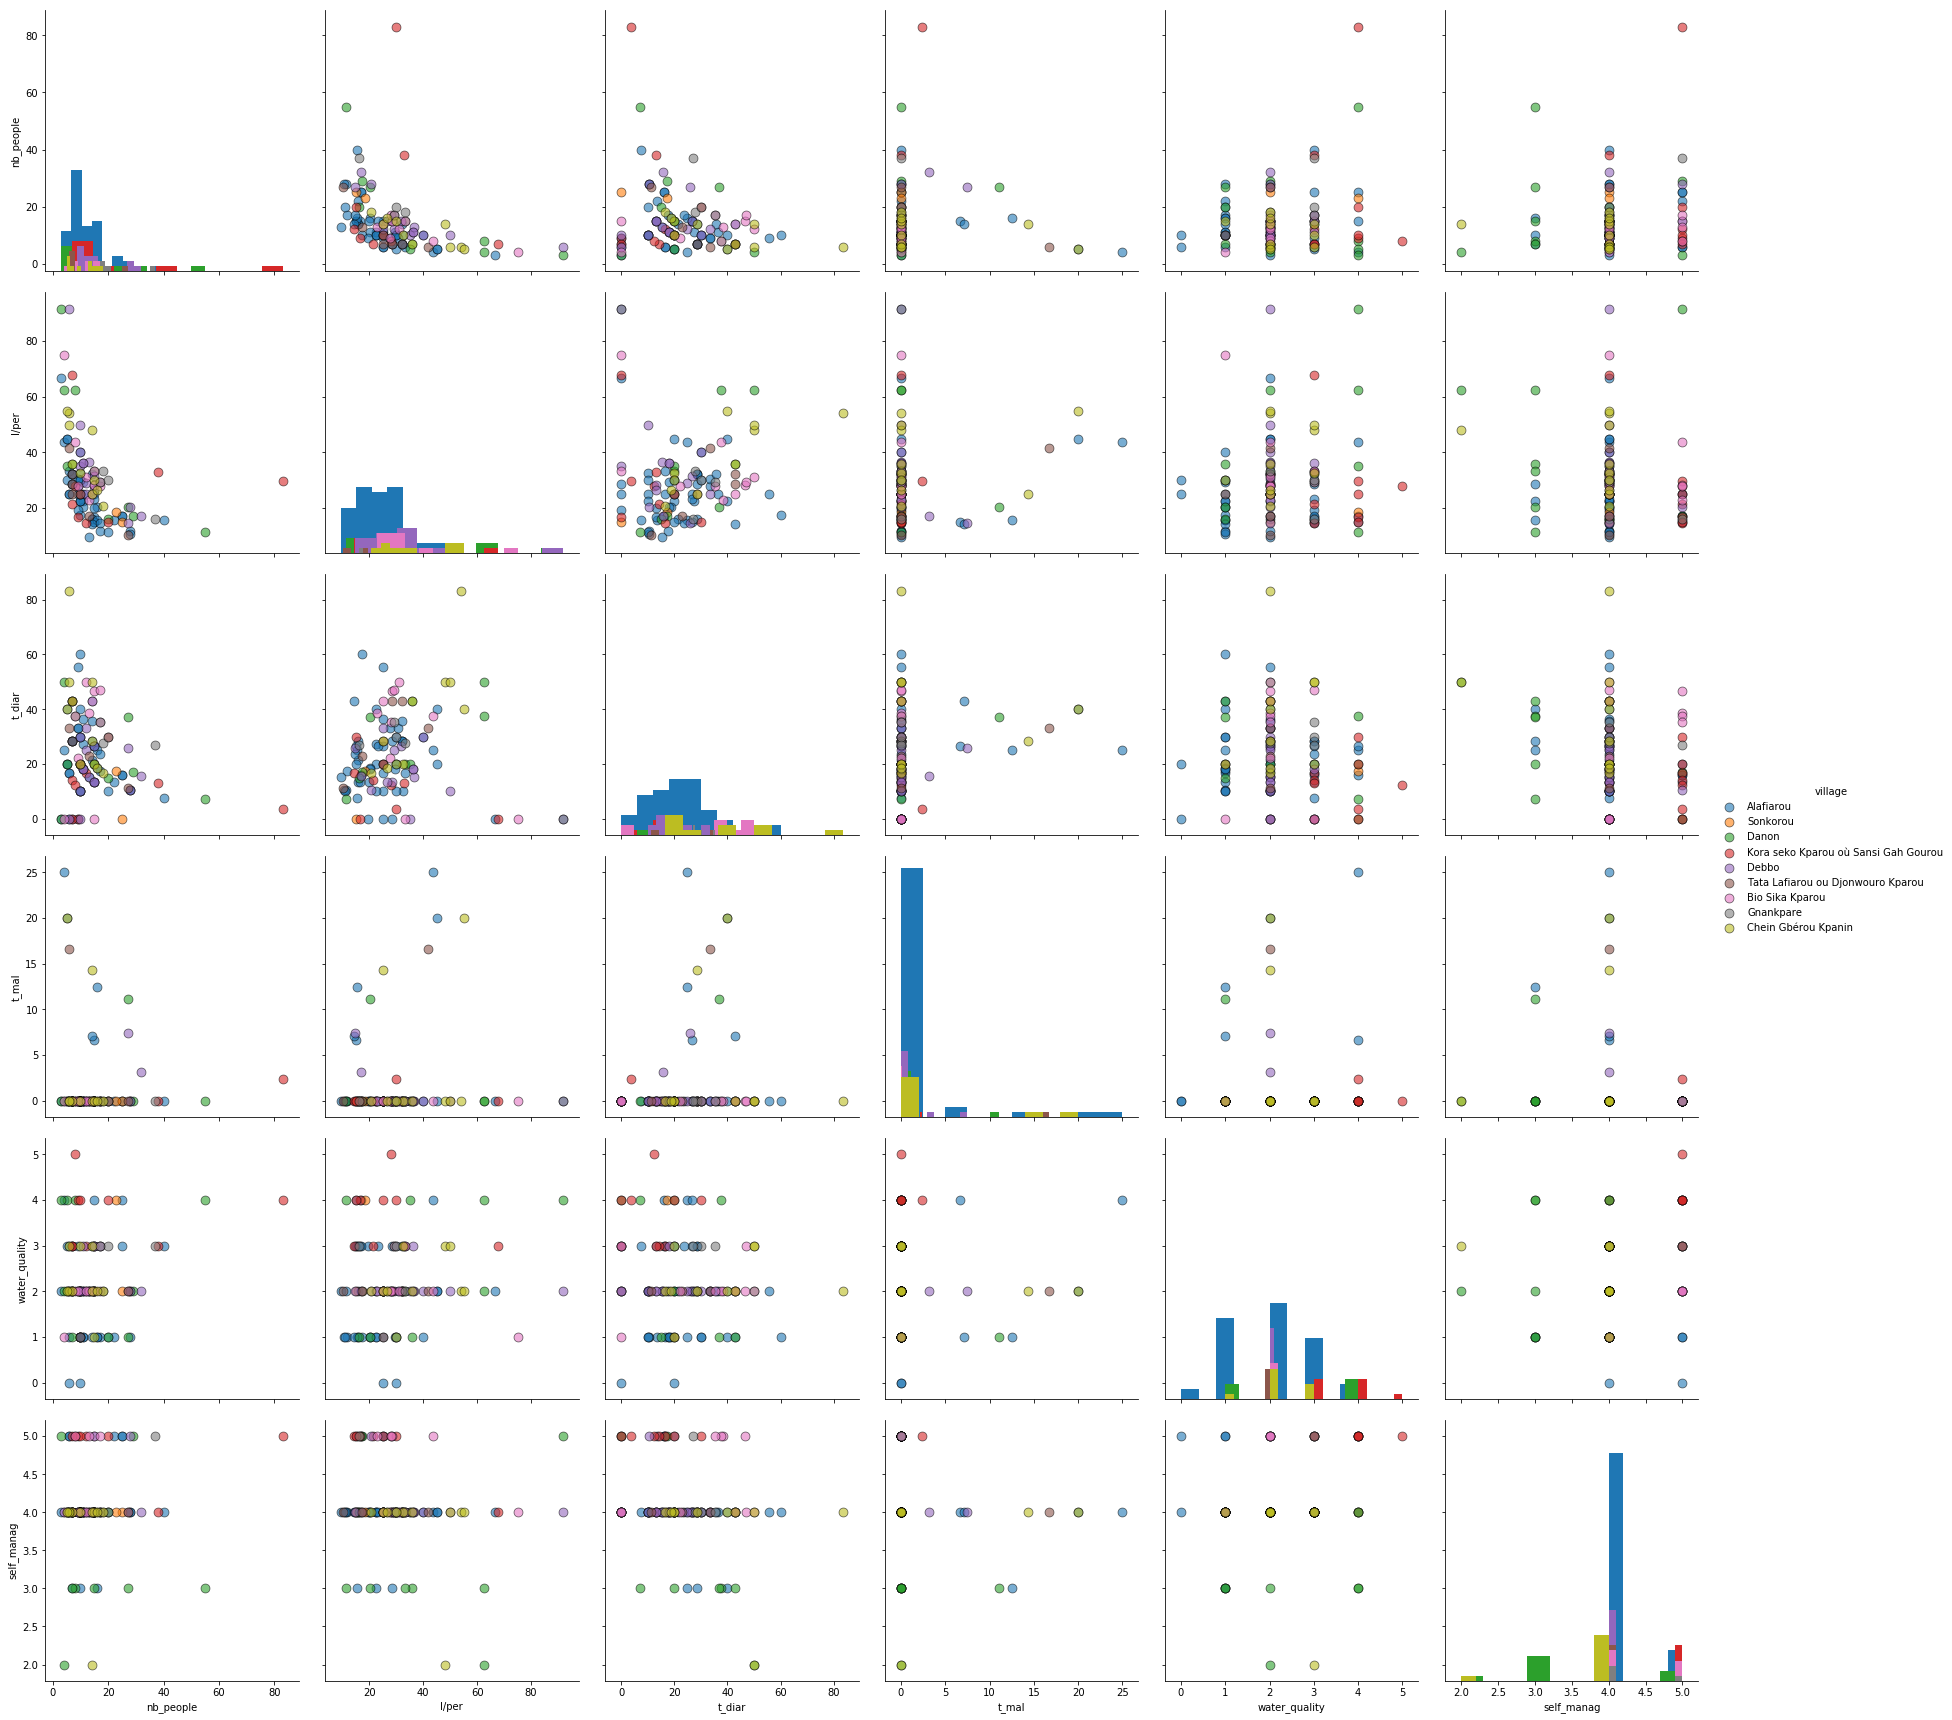

In [48]:
df_correlations = df_priority[['village','nb_people','l/per','t_diar',
                               't_mal','water_quality','self_manag']].copy()

sns.pairplot(df_correlations, hue = 'village', diag_kind = 'hist',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)
plt.show()

## RELATION BETWEEN DIARREAH AND l/per

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


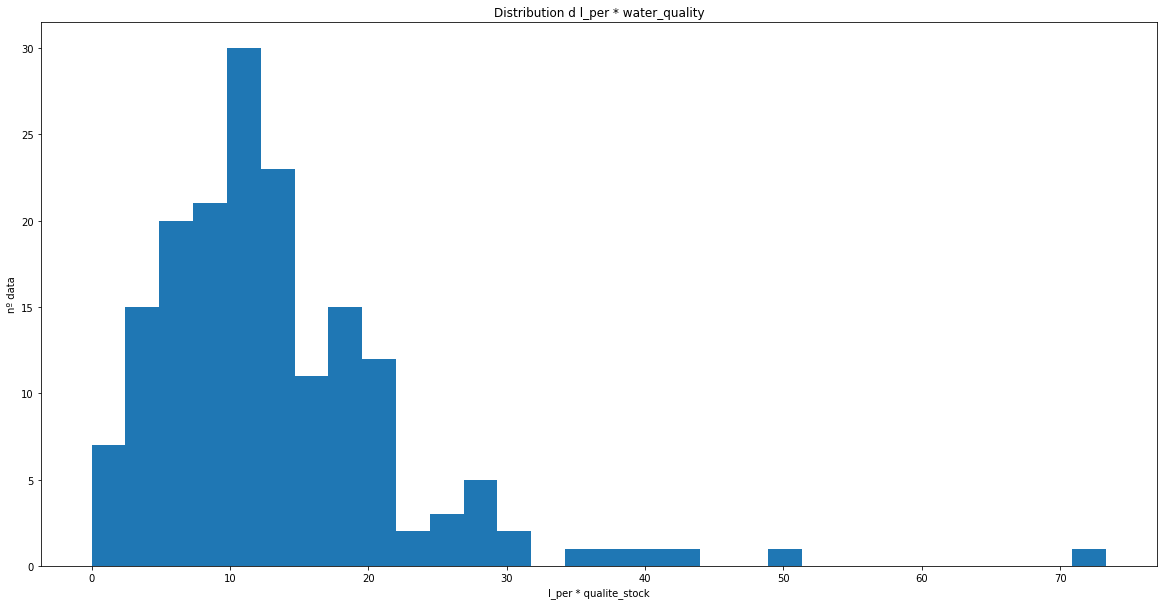

In [390]:
f, ax = plt.subplots(1, figsize=(20,10))

x=df_priority['l_per']*(df_priority['water_quality']/5)

ax.hist(x,bins=30)

ax.set_xlabel('l_per * qualite_stock')

ax.set_ylabel('nº data')

ax.set_title("Distribution d l_per * water_quality")

plt.show()

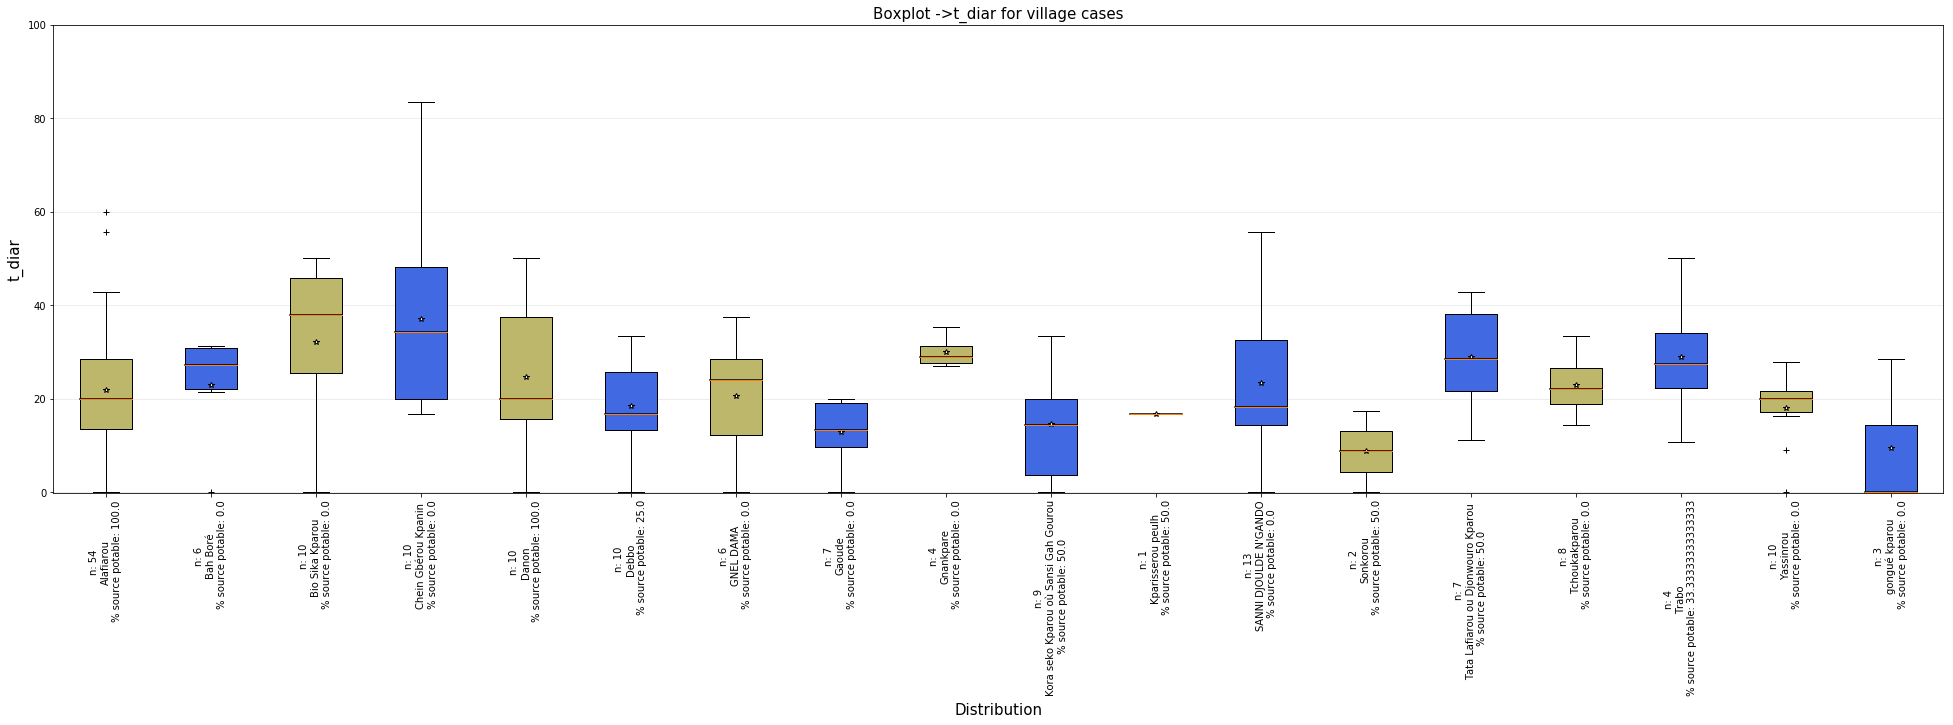

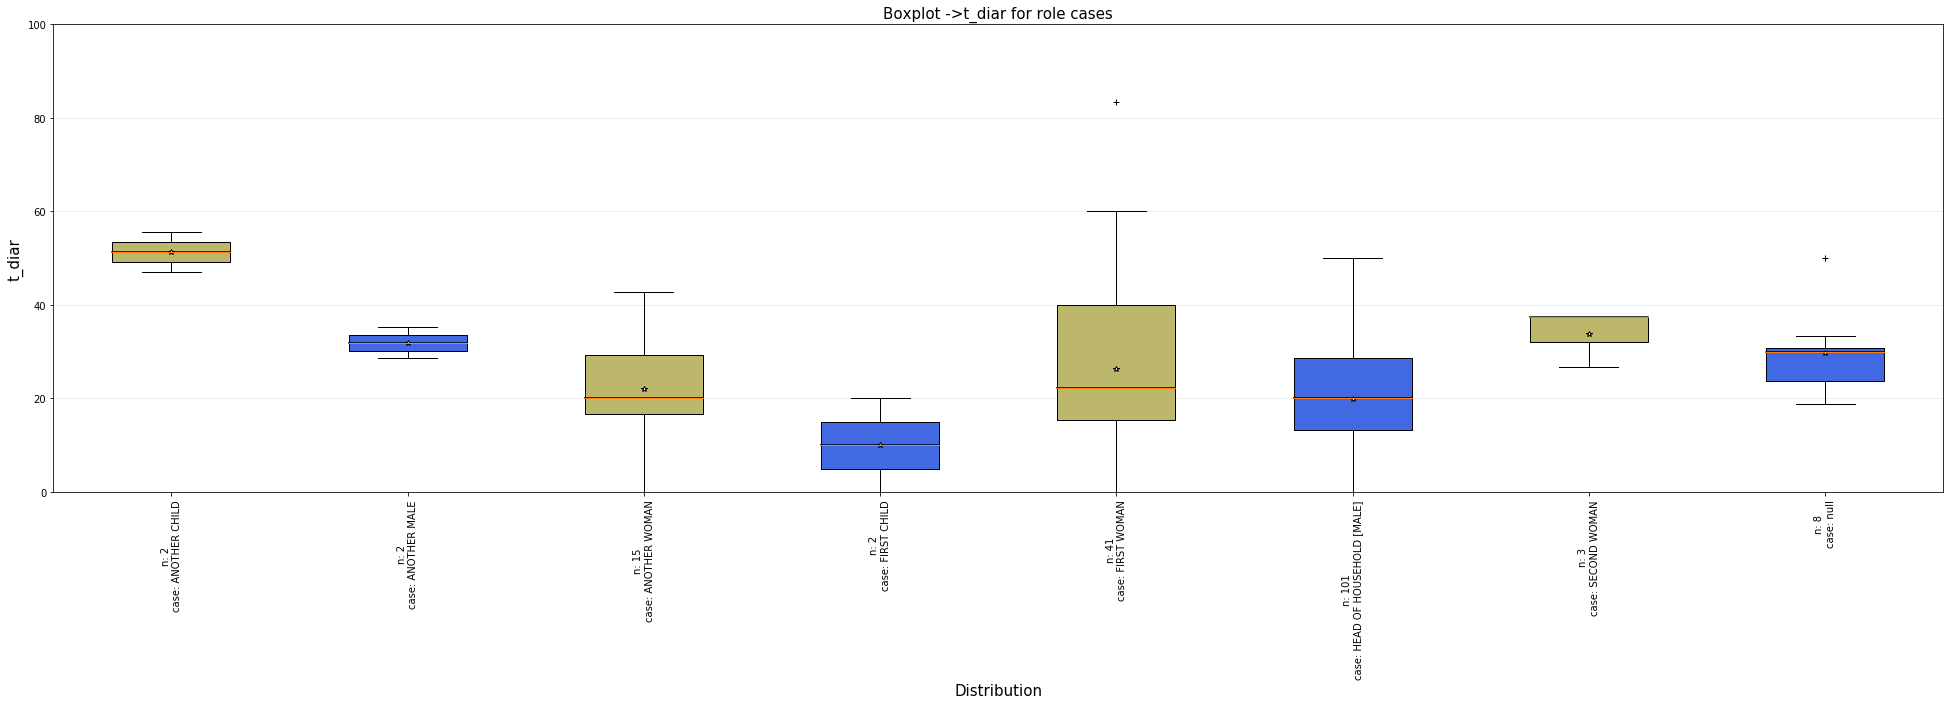

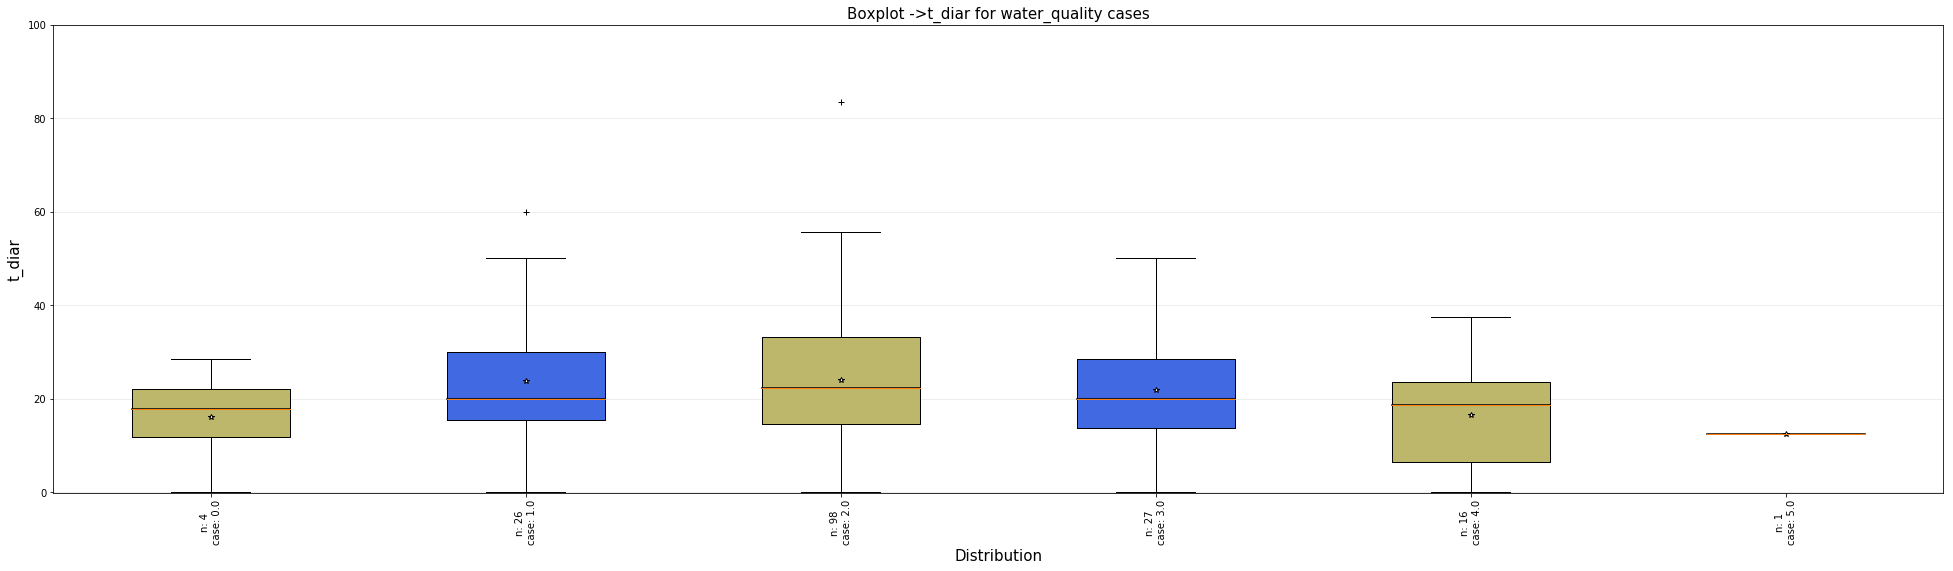

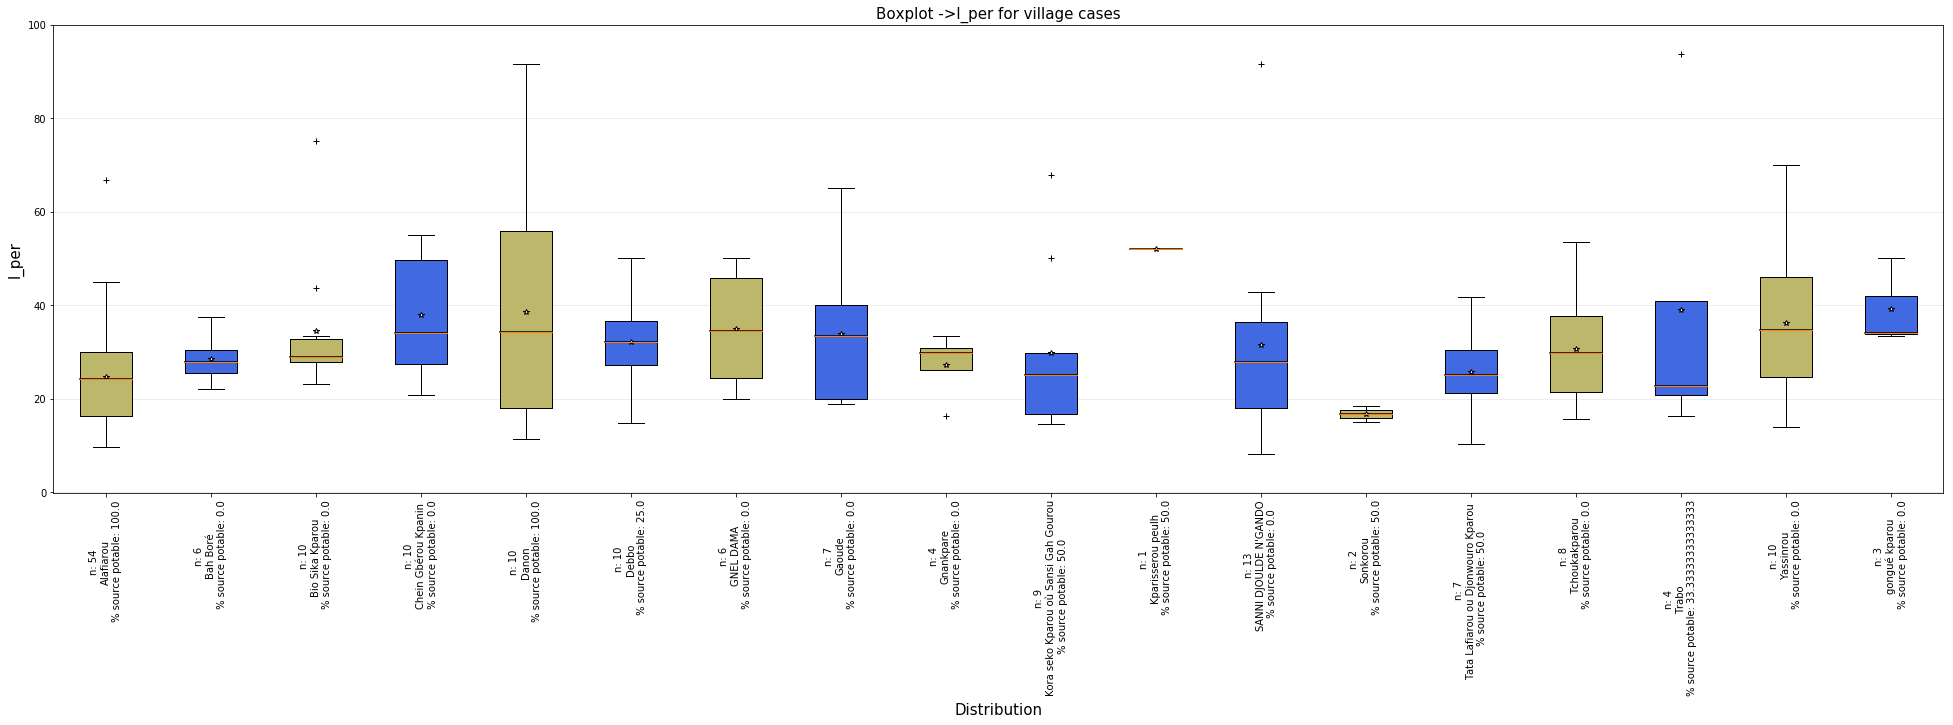

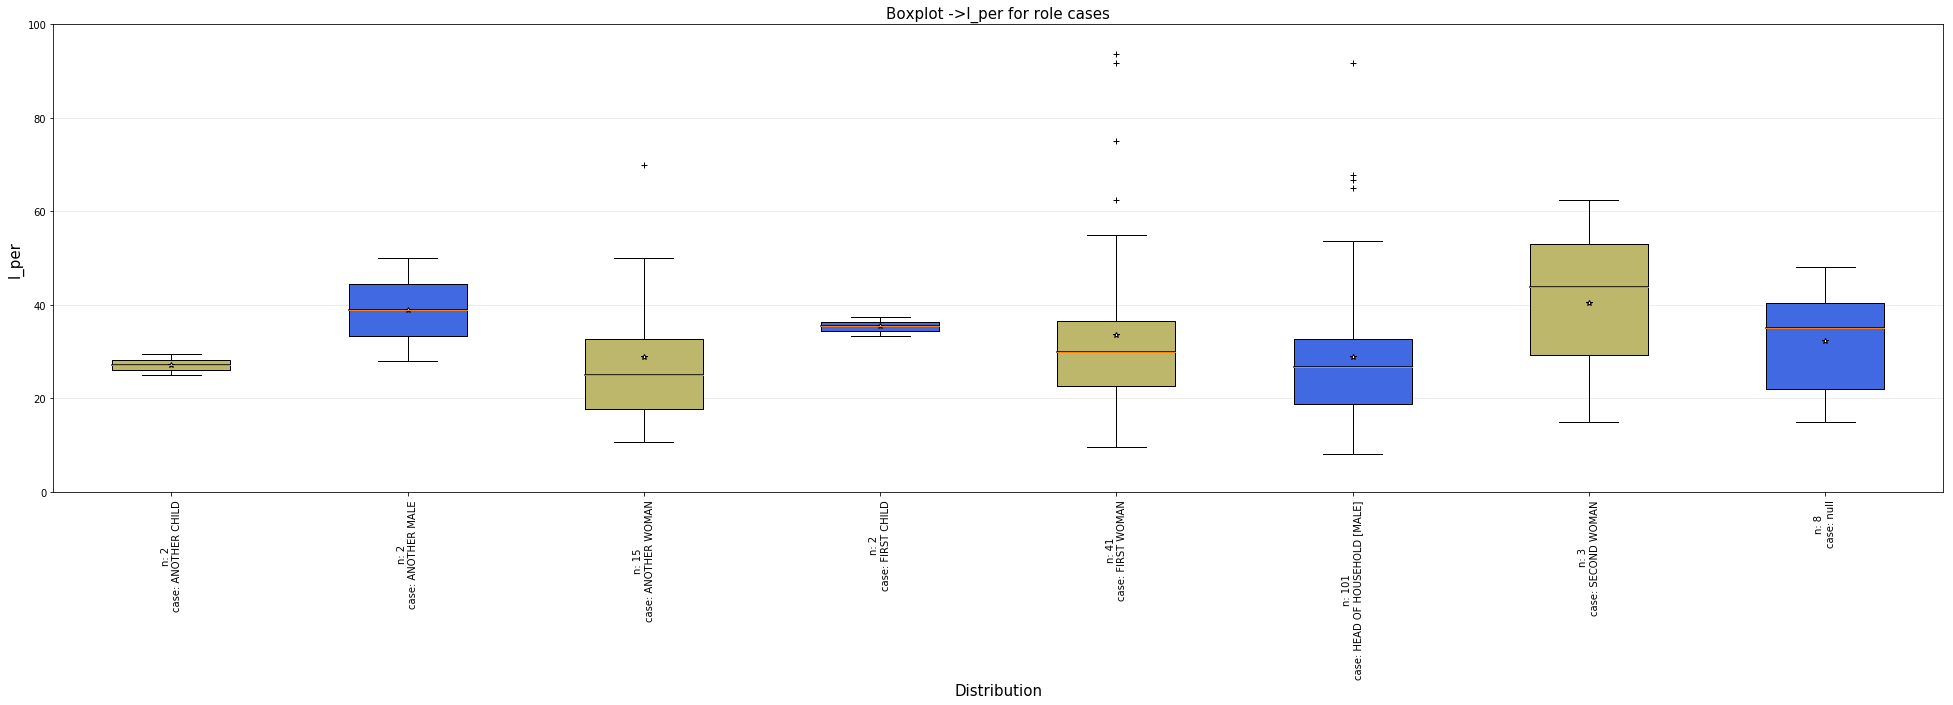

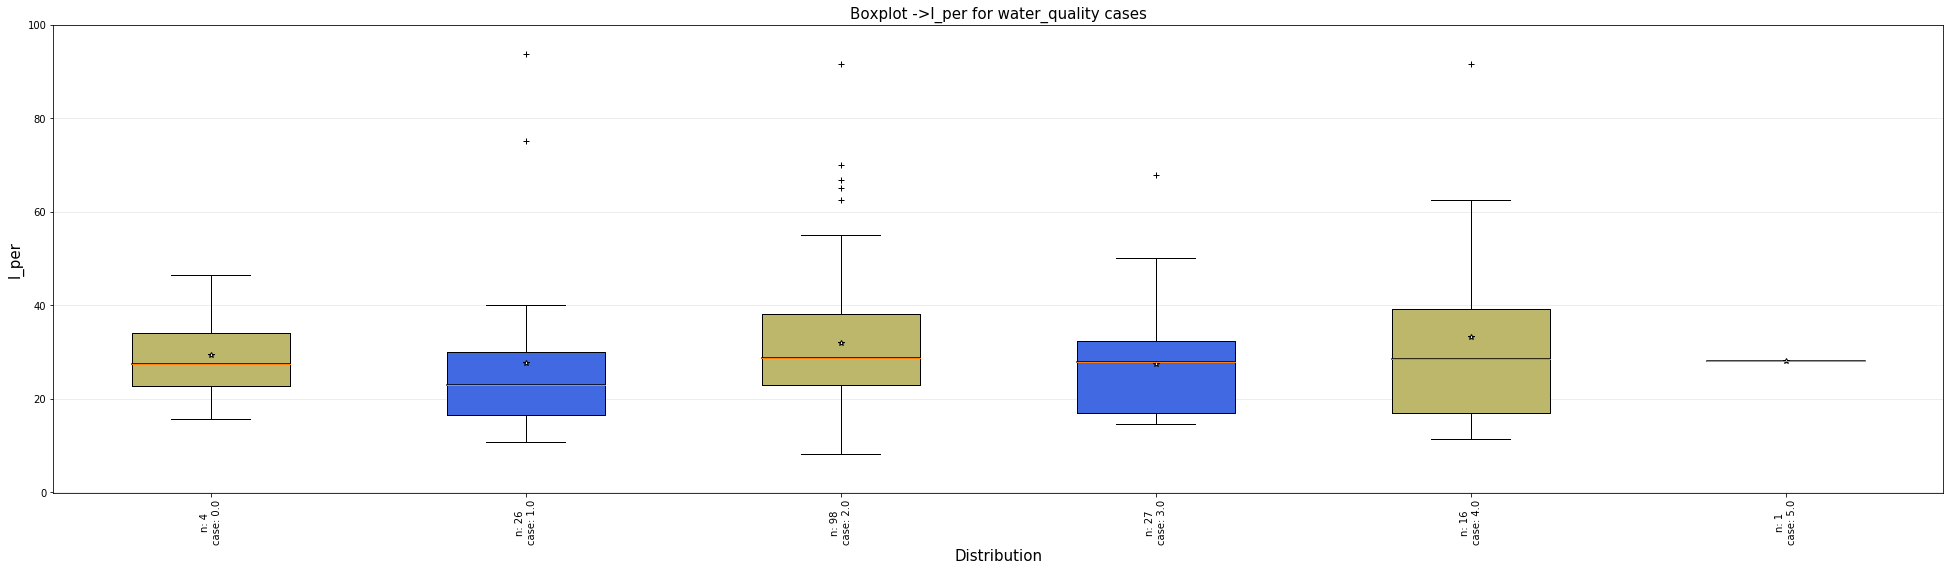

In [391]:
z=2

datas_to_filter=['village','role','water_quality']
values_to_show=['t_diar','l_per']
for value in values_to_show:
    for data_to_filter in datas_to_filter:
        cases=df_priority[data_to_filter].sort_values().dropna().unique()
        #wat_qual=df_priority['role'].sort_values().dropna().unique()
        data = [df_priority[df_priority[data_to_filter]==a][value] for a in cases]
        data_size= [len(a) for a in data]
        if data_to_filter == 'village':
            labels = ['n: '+str(data_siz)+'\n'+str(case)+'\n % source potable: '+str(df_village[df_village['village_name']==case]['%_s_potable'].values[0])
                      for data_siz,case in zip(data_size,cases)]
        else:
             labels = ['n: '+str(data_siz)+'\ncase: '+str(case)
                      for data_siz,case in zip(data_size,cases)]
        fig, ax1 = plt.subplots(figsize=(30, 10))
        #fig, ax1 = plt.subplots(figsize=(10, 6))

        fig.canvas.set_window_title('A Boxplot Example')
        fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

        bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
        plt.setp(bp['boxes'], color='black')
        plt.setp(bp['whiskers'], color='black')
        plt.setp(bp['fliers'], color='red', marker='+')

        # Add a horizontal grid to the plot, but make it very light in color
        # so we can use it for reading data values but not be distracting
        ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                       alpha=0.5)

        # Hide these grid behind plot objects
        ax1.set_axisbelow(True)
        ax1.set_title('Boxplot ->'+value+' for '+data_to_filter + ' cases',fontsize=15)
        ax1.set_xlabel('Distribution',fontsize=15)
        ax1.set_ylabel(value,fontsize=15)


        # Now fill the boxes with desired colors
        boxColors = ['darkkhaki', 'royalblue']
        numBoxes = len(cases)
        medians = list(range(numBoxes))
        for i in range(numBoxes):
            box = bp['boxes'][i]
            boxX = []
            boxY = []
            for j in range(5):
                boxX.append(box.get_xdata()[j])
                boxY.append(box.get_ydata()[j])
            boxCoords = np.column_stack([boxX, boxY])
            # Alternate between Dark Khaki and Royal Blue
            k = i % 2
            boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
            ax1.add_patch(boxPolygon)
            # Now draw the median lines back over what we just filled in
            med = bp['medians'][i]
            medianX = []
            medianY = []
            for j in range(2):
                medianX.append(med.get_xdata()[j])
                medianY.append(med.get_ydata()[j])
                ax1.plot(medianX, medianY, 'k')
                medians[i] = medianY[0]
            # Finally, overplot the sample averages, with horizontal alignment
            # in the center of each box
            ax1.plot([np.average(med.get_xdata())], [np.average(data[i])],
                     color='w', marker='*', markeredgecolor='k')

        # Set the axes ranges and axes labels
        ax1.set_xlim(0.5, numBoxes + 0.5)
        top = 100
        bottom = -10
        ax1.set_ylim(-0.1, top)
        ax1.set_xticklabels(labels,
                            rotation=90, fontsize=10)
        #ax1.set_xticklabels(list(csvData[z].index),
                            #rotation=45, fontsize=8)

        plt.show()

### to export to plotly

In [62]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf

In [63]:
df_priority.pivot_table(values='l/per',columns='village')

village,Alafiarou,Bio Sika Kparou,Chein Gbérou Kpanin,Danon,Debbo,Gnankpare,Kora seko Kparou où Sansi Gah Gourou,Sonkorou,Tata Lafiarou ou Djonwouro Kparou
l/per,24.630128,34.487431,37.799107,38.593967,34.620251,27.240329,27.930525,16.73913,25.696261


In [64]:
import os
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output


### dash with selection for village and diarhea

In [74]:
df = df_priority
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

if 'DYNO' in os.environ:
    app_name = os.environ['DASH_APP_NAME']
else:
    app_name = 'dash-boxplot'

app.layout = html.Div([html.Div([
        html.H1("Taux de diarhee selon village")], style={"textAlign": "center"}),
        dcc.Graph(id="my-graph"),
        html.Div([dcc.RangeSlider(id="selected-qualite",min=0,max=5,
                 marks={0: "0", 1: "1", 2: "2", 3: "3",4: "4",5: "5",},value=[0, 2],)],
                 style={"display": "block","margin-left": "auto","margin-right": "auto","width": "60%"}),
], className="container")


@app.callback(
    Output('my-graph', 'figure'),
    [Input('selected-qualite', 'value')])
def update_figure(selected):
    dff = df[(df["water_quality"] >= selected[0]) & (df["water_quality"] <= selected[1])]
    traces = []
    for vil in dff.village.unique():
        traces.append(go.Box(y=dff[dff["village"] == vil]["t_diar"],name=vil,marker={"size": 4}))
    return {"data": traces,
            "layout": go.Layout(title=f"Taux de diarrhee selon qualité{'-'.join(str(i) for i in selected)}",autosize=True,
                                margin={"l": 200, "b": 100, "r": 200},xaxis={"showticklabels": False,},
                                yaxis={"title": f"t_diar",},)}


In [75]:
app.run_server(debug=True)

Running on http://127.0.0.1:8050/
Debugger PIN: 973-314-536
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



#### dash for role that reply

In [65]:
df = df_priority
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

if 'DYNO' in os.environ:
    app_name = os.environ['DASH_APP_NAME']
else:
    app_name = 'dash-boxplot'
    
#options for radioitems
all_options=df_priority.village.unique()

app.layout = html.Div([html.Div([
        html.H1("Taux de diarhee selon village")], style={"textAlign": "center"}),
        dcc.Graph(id="my-graph"),
        html.Div([
            
               dcc.RadioItems(
                id='selected-role',
                options=[{'label': k, 'value': k} for k in all_options],
                value=all_options[0]
    ),
        ],
                 style={"display": "block","margin-left": "auto","margin-right": "auto","width": "60%"}
        ),
], className="container")


@app.callback(
    Output('my-graph', 'figure'),
    [Input('selected-role', 'value')])
def update_figure(selected):
    dff = df[df["village"] == selected]
    traces = []
    for rol in dff.role.unique():
        traces.append(go.Box(y=dff[dff["role"] == rol]["t_diar"],name=rol,marker={"size": 4}))
    return {"data": traces,
            "layout": go.Layout(
                title=f"Taux de diarrhee selon roles dans village "+selected+'\n\n n= '+str(len(dff)),
                margin={"l": 200, "b": 100, "r": 200},xaxis={"showticklabels": False,},
                yaxis={"title": f"t_diar",},
            )
           }


In [66]:
app.run_server(debug=True)

Running on http://127.0.0.1:8050/
Debugger PIN: 470-367-800
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



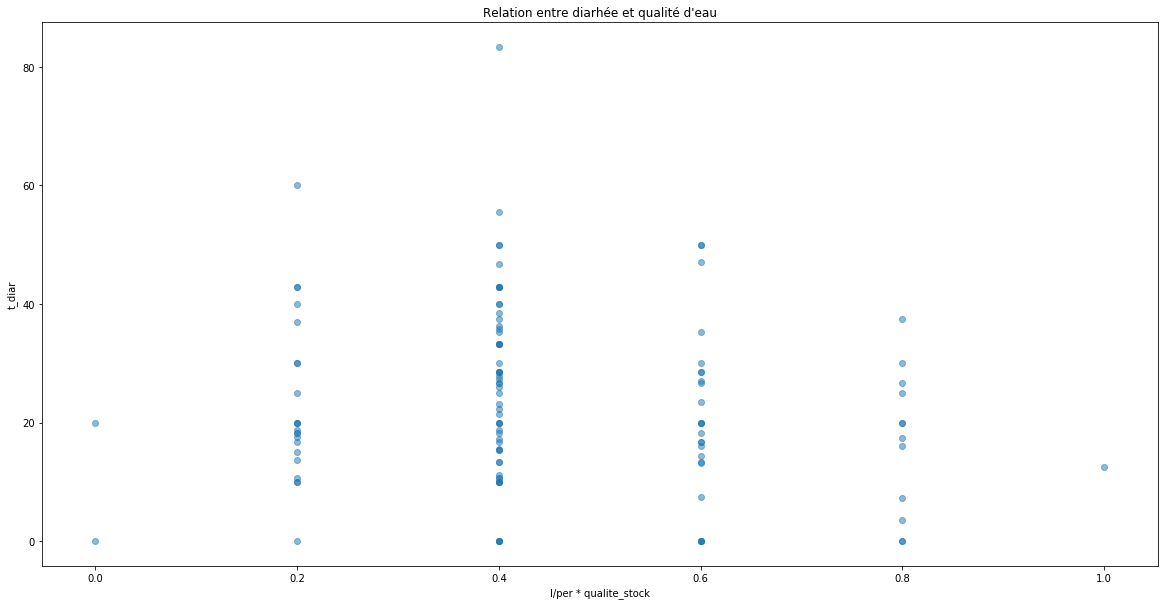

In [68]:
f, ax = plt.subplots(1, figsize=(20,10))

#x=df_priority['l/per']*(df_priority['water_quality']/5)

wat_qual=df_priority['water_quality'].sort_values().dropna().unique()
x=df_priority['water_quality']/5
y=df_priority['t_diar']

ax.scatter(x,y,alpha=0.5)

ax.set_xlabel('l/per * qualite_stock')

ax.set_ylabel('t_diar')

ax.set_title("Relation entre diarhée et qualité d'eau")

plt.show()

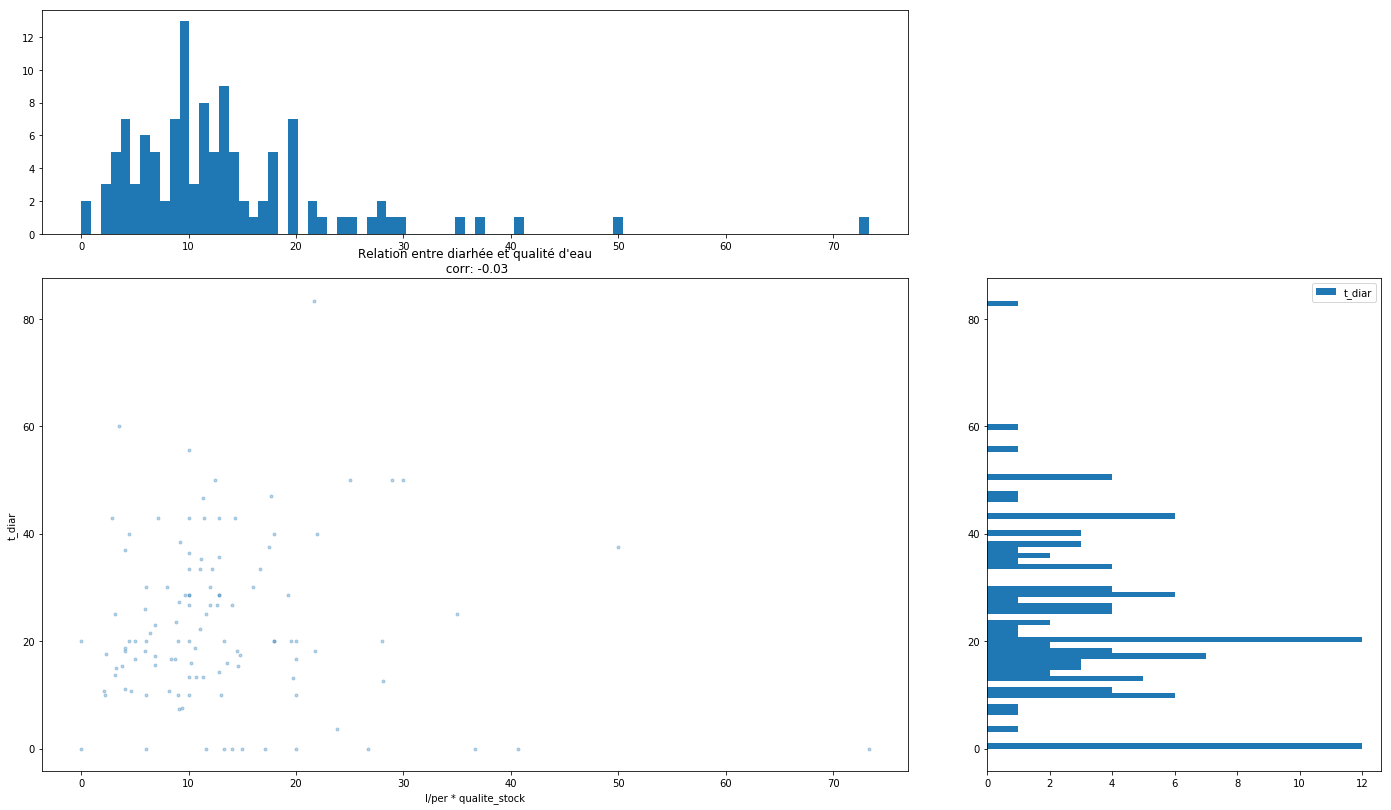

In [258]:
 # Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

df_plot=df_priority[(df_priority['l/per'].notnull()) &
         (df_priority['water_quality'].notnull()) &
         (df_priority['t_diar'].notnull())]

x=df_plot['l/per']*(df_plot['water_quality']/5)
#x=df_plot['water_quality']
y=df_plot['t_diar']

total_x, total_y = (np.array(x),np.array(y))

R2 = str(round(np.corrcoef(total_x, total_y)[1][0],2))

#scatter of variation in score and coverage relative variation and their histogram
scatter_axes = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
pyplot.title("Relation entre diarhée et qualité d'eau"+ "\n corr: " + R2)
pyplot.rcParams["figure.figsize"] = [24,14]
pyplot.xlabel("l/per * qualite_stock")
#pyplot.xlabel("qualite_stock")
pyplot.ylabel("t_diar")


x_hist_axes = plt.subplot2grid((3, 3), (0, 0), colspan=2,
                       sharex=scatter_axes)
y_hist_axes = plt.subplot2grid((3, 3), (1, 2), rowspan=2,
                       sharey=scatter_axes)

scatter_axes.plot(x, y, '.',alpha=0.3)
x_hist_axes.hist(x,bins=80)

y_hist_axes.hist(y, orientation='horizontal',bins=80)

pyplot.legend()
pyplot.show()

## DETERMINAR N MUESTRAL

<a href="https://towardsdatascience.com/how-to-use-python-to-figure-out-sample-sizes-for-your-study-871f0a76a19c">SOURCE</a>

In [116]:
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [117]:
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

In [138]:
p_diffs = [x*.01 for x in range(10,40)]

data = []
for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial probability'] = '20%'
    data.append(record)

for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.01)
    record['Confidence Level'] = '99%'
    record['Initial probability'] = '20%'
    data.append(record)

df = pd.DataFrame(data)

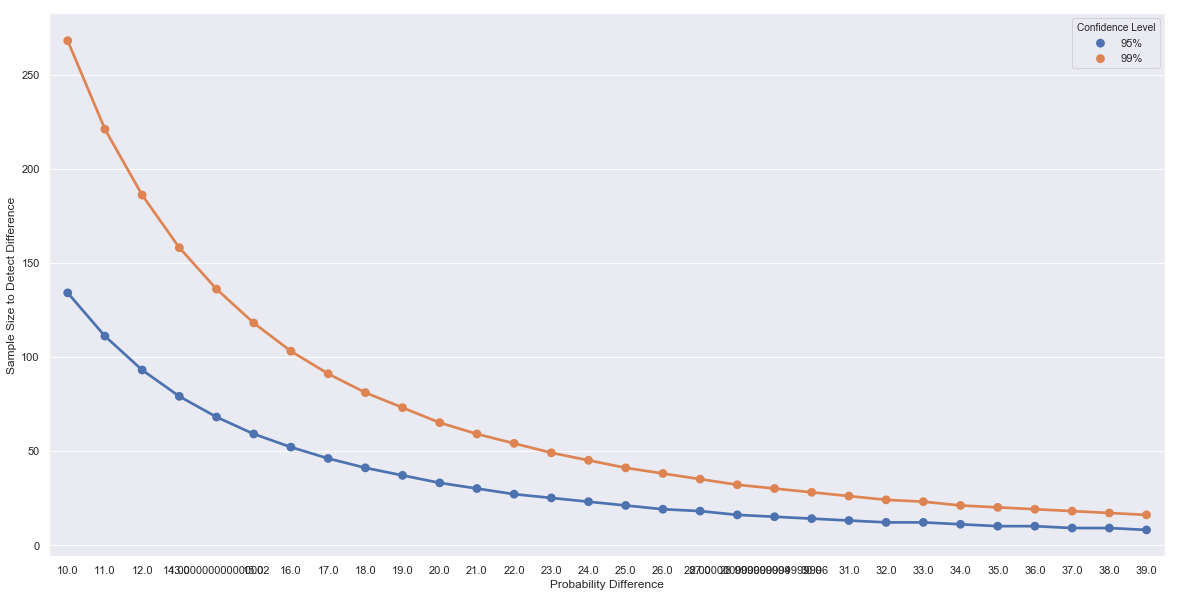

In [142]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(20, 10))

sns.set(style='darkgrid')

plot = sns.pointplot(x='Probability Difference',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)